# Compare vaccination strategies. $e$=0.7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime
from experiments import get_experiments_results
from env_var import EPIDEMIC, MAPPINGS, EXPERIMENTS

mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
# Simulation parameters
num_age_groups = EXPERIMENTS['num_age_groups']
num_ervas = EXPERIMENTS['num_ervas']
T = EXPERIMENTS['simulate_T']
init_vacc = EXPERIMENTS['init_vacc']
inc_mob = EXPERIMENTS['inc_mob']
u = EXPERIMENTS['vaccines_per_day']
r_experiments = EXPERIMENTS['r_effs']
t0 = EXPERIMENTS['t0']
e = EPIDEMIC['e']
strategies = EXPERIMENTS['strategies']

# Plot parameters
plot_interval = 15
ervas_labels = EPIDEMIC['ervas_order']
age_labels = MAPPINGS['age_groups'][num_age_groups]['names']
color_palette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

In [3]:
all_results = get_experiments_results(num_age_groups=num_age_groups,
                                      num_ervas=num_ervas,
                                      init_vacc=init_vacc,
                                      strategies=strategies,
                                      u=u,
                                      T=T,
                                      r_experiments=r_experiments,
                                      t0=t0,
                                      e=e,
                                      inc_mob=inc_mob)

Beginning experiments.
Parameters:
Number of age ervas: 5.
Number of age groups: 9.
Number of vaccines per day: 30000.
rho: 42.269217817616585.
t0: 2021-04-18.
T: 115.
Vaccine efficacy (e): 0.7.
Rs to try: [0.75, 1.0, 1.25, 1.5, 2.0].
Initialize with vaccinated people: True.
Include mobility: True.
Strategies:
[([1, 0, 0], 'Pop only'), ([0, 0, 0], 'No vaccination'), ([0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 'Pop, Inf and Hosp'), ([0.5, 0, 0.5], 'Pop and Hosp'), ([0.5, 0.5, 0], 'Pop and Inf'), ([0, 0.5, 0.5], 'Hosp and Inf'), ([0, 0, 1], 'Hosp only'), ([0, 1, 0], 'Inf only'), (None, 'Optimal')].

Finished R: 0.75. Beta: 0.017743408530437054 1/5. Policy: Pop only. 1/9
Finished R: 0.75. Beta: 0.017743408530437054 1/5. Policy: No vaccination. 2/9
Finished R: 0.75. Beta: 0.017743408530437054 1/5. Policy: Pop, Inf and Hosp. 3/9
Finished R: 0.75. Beta: 0.017743408530437054 1/5. Policy: Pop and Hosp. 4/9
Finished R: 0.75. Beta: 0.017743408530437054 1/5. Policy: Pop and Inf

In [4]:
def plot_results(ax, r, metric, all_results, t0, T, skip_no_vacc=True):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    x = [begin + datetime.timedelta(days=day) for day in range(T)]

    results_for_r = all_results[r]
    totals = []
    label_i = 0
    for label, results_all_metrics in results_for_r:
        if label == 'No vaccination' and skip_no_vacc:
            continue
        metric_results = results_all_metrics[metric]
        metric_all_time = metric_results.sum(axis=0)
        metric_all_time = metric_all_time.sum(axis=0)
        
        assert metric_all_time.shape[0] == T
        
        ax.plot(x, metric_all_time, label=label, color=color_palette[label_i])
        if metric == 'deaths':
            total_policy = metric_all_time[-1]
        else:
            total_policy = metric_all_time.sum(axis=0)
        total = (label, total_policy)
        totals.append(total)
        label_i += 1
        
    sorted_totals = sorted(totals, key=lambda x: x[-1])
    for total in sorted_totals:
        print('%s: %s' % (total[0], total[1]))
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of %s.' % (metric, ))
    ax.set_title('Number of %s per policy. R=%s' % (metric, r))
    ax.legend()
        
    return ax

# Deaths

Inf only: 103.2996350652798
Hosp and Inf: 103.31860874594989
Hosp only: 103.34608284095773
Pop, Inf and Hosp: 103.42861048241346
Optimal: 103.4345702776016
Pop and Inf: 103.48779624476781
Pop and Hosp: 103.51385616755739
Pop only: 103.7766536000819


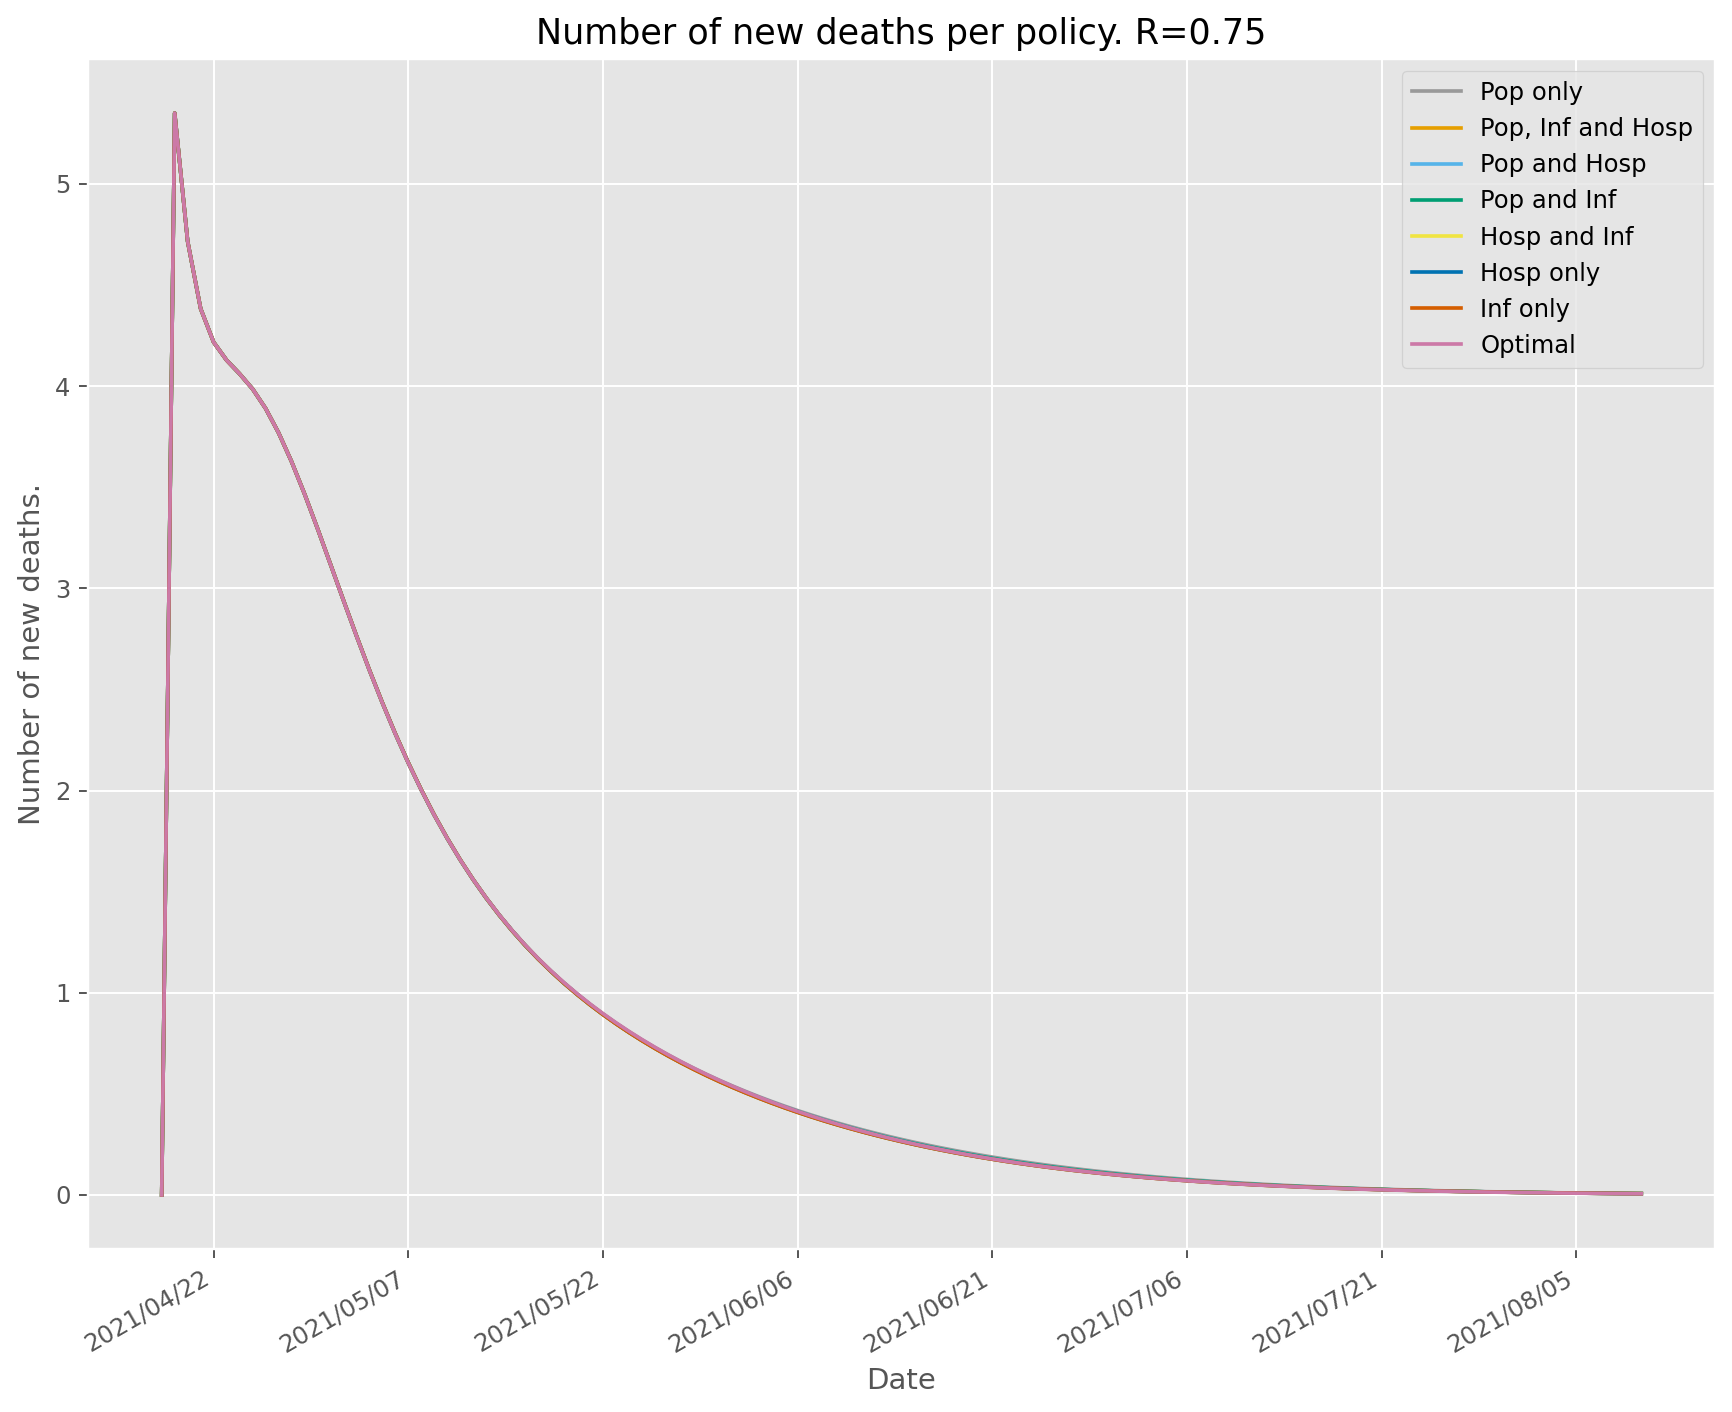

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[0], metric='new deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Inf only: 185.66033183393083
Optimal: 185.74370926878606
Hosp and Inf: 185.8463090508096
Hosp only: 186.06037271334864
Pop, Inf and Hosp: 186.59726133232851
Pop and Inf: 187.03474160801753
Pop and Hosp: 187.22689609046543
Pop only: 189.5631074248375


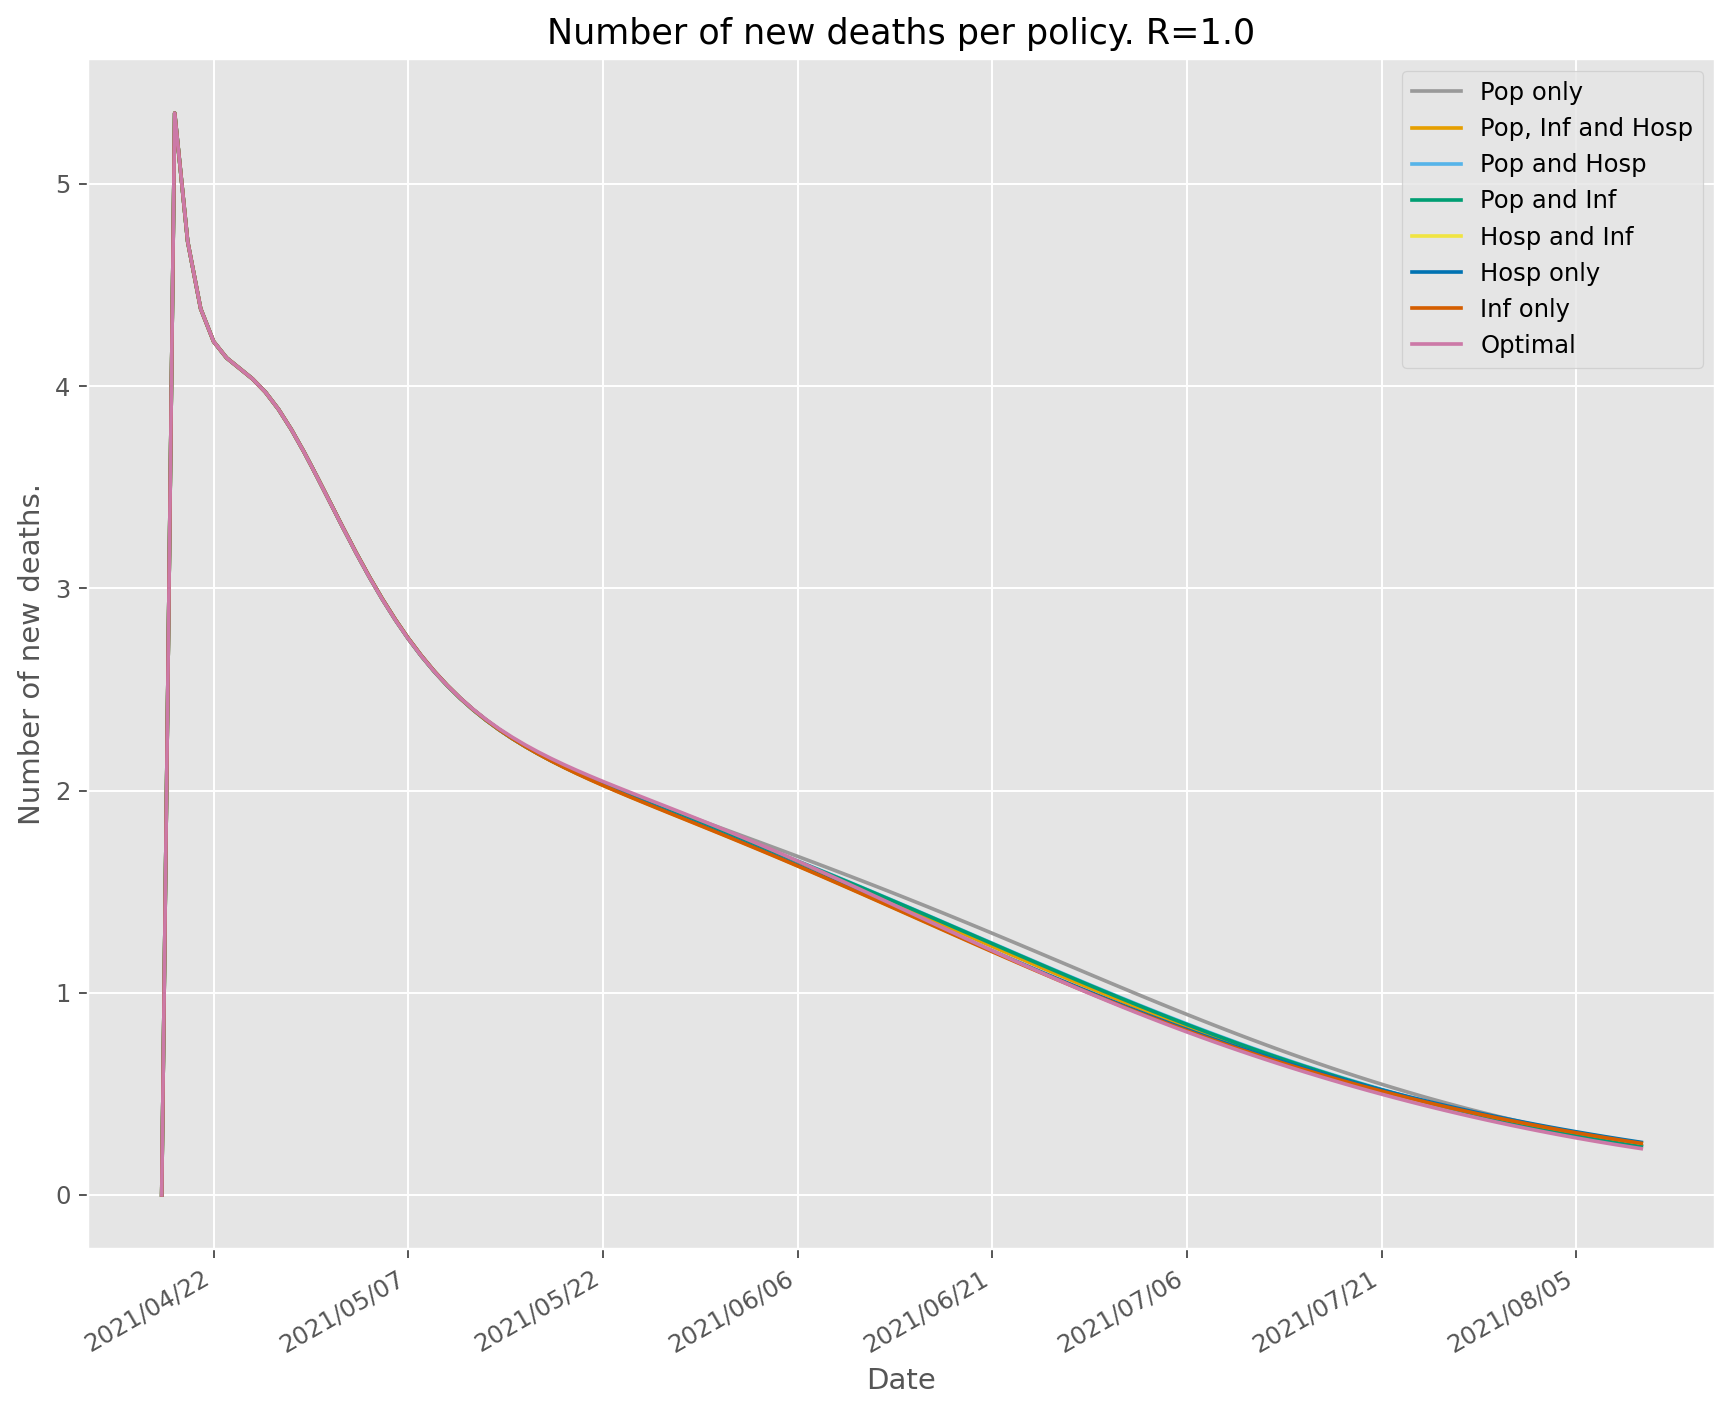

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='new deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Optimal: 592.9730757530515
Inf only: 605.0110050238884
Pop and Inf: 605.497093505437
Pop, Inf and Hosp: 605.6242075306393
Hosp and Inf: 606.7354952191497
Pop and Hosp: 607.1489601472483
Hosp only: 608.6312374223702
Pop only: 617.7640136464838


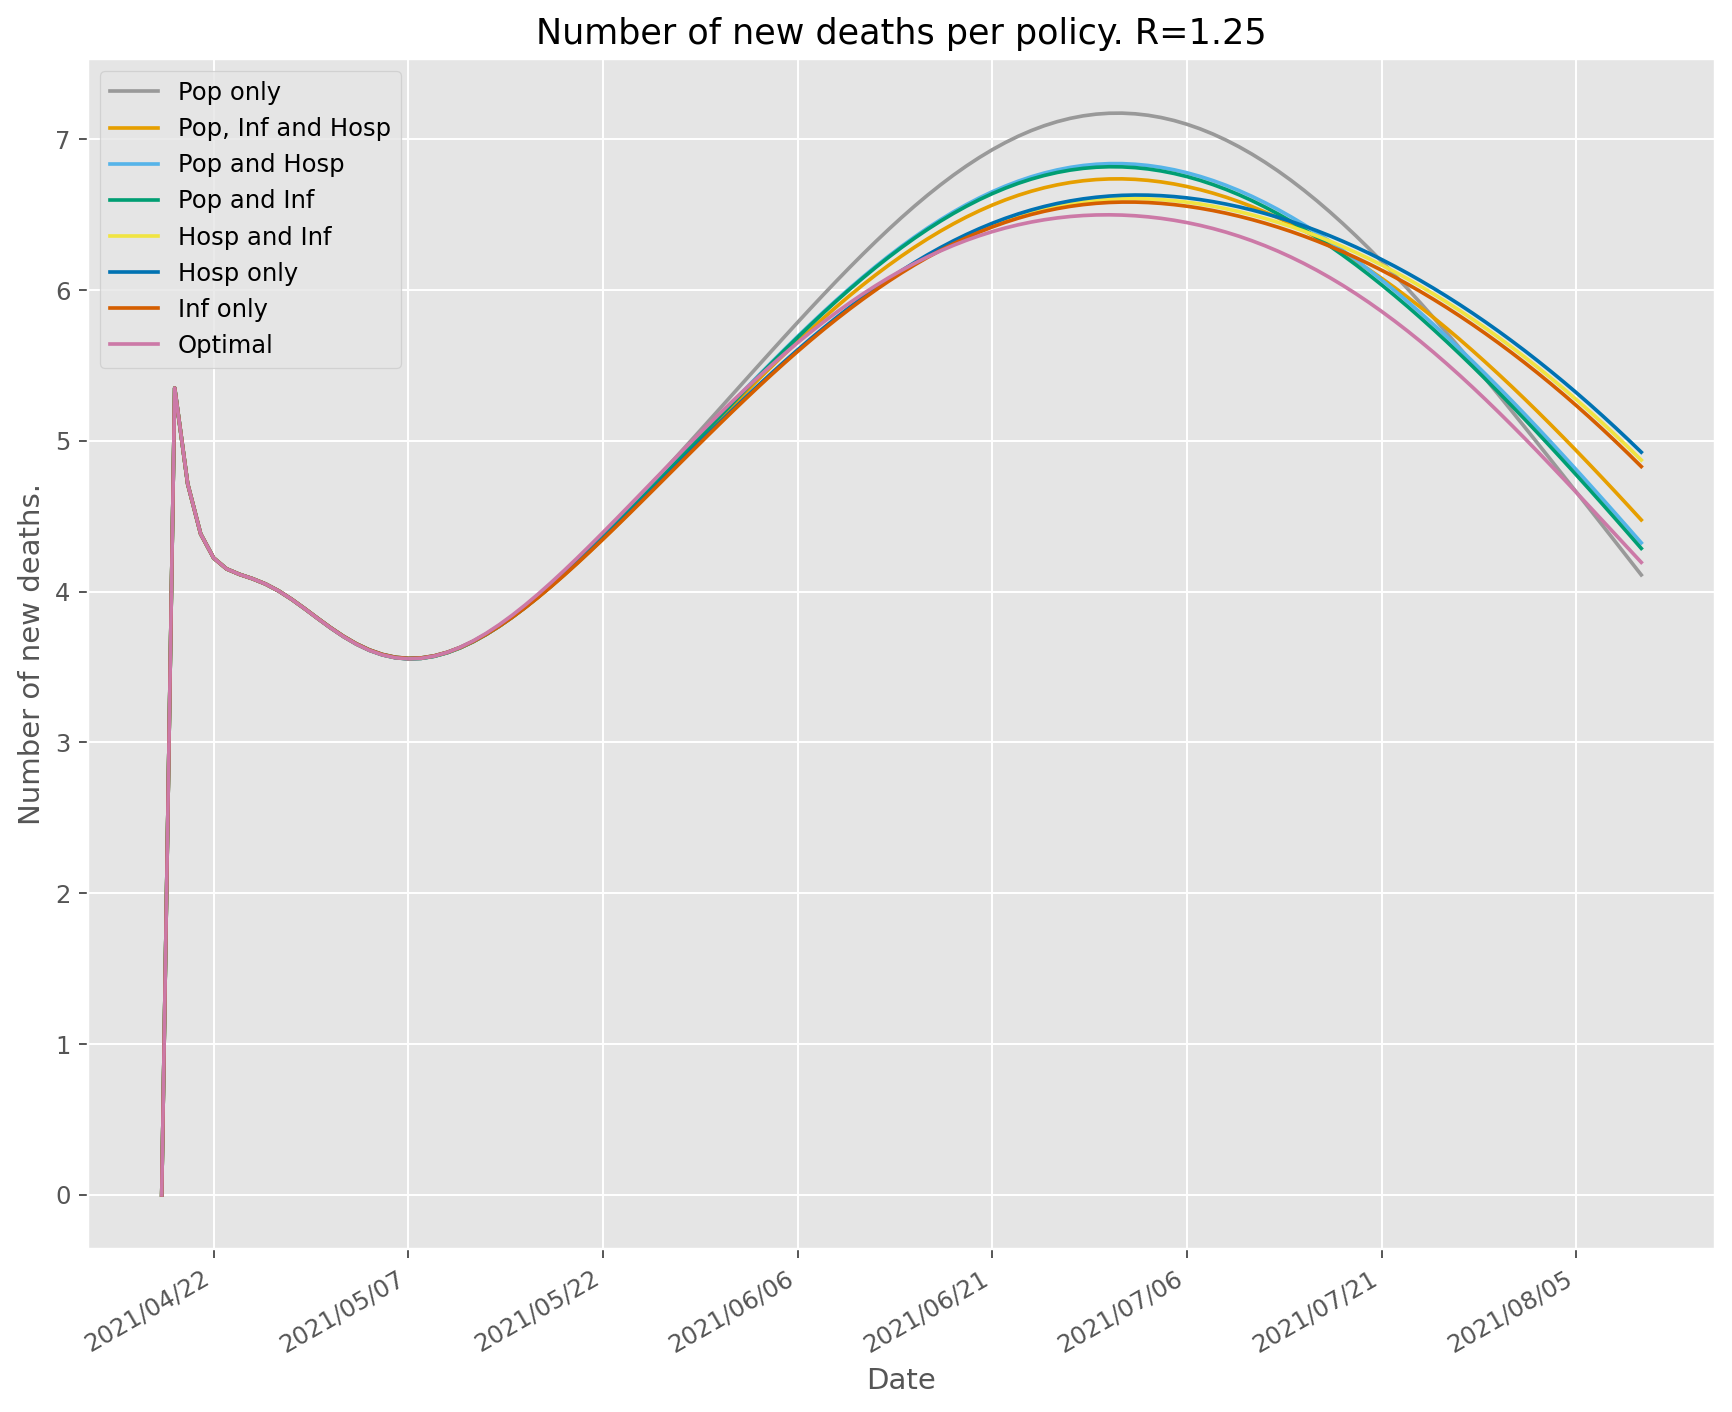

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='new deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Optimal: 2243.86192552704
Pop only: 2286.0564756650783
Pop and Inf: 2296.8098312719635
Pop and Hosp: 2304.505832225959
Pop, Inf and Hosp: 2316.4384006742494
Inf only: 2347.212618402432
Hosp and Inf: 2354.486173819286
Hosp only: 2362.67611045042


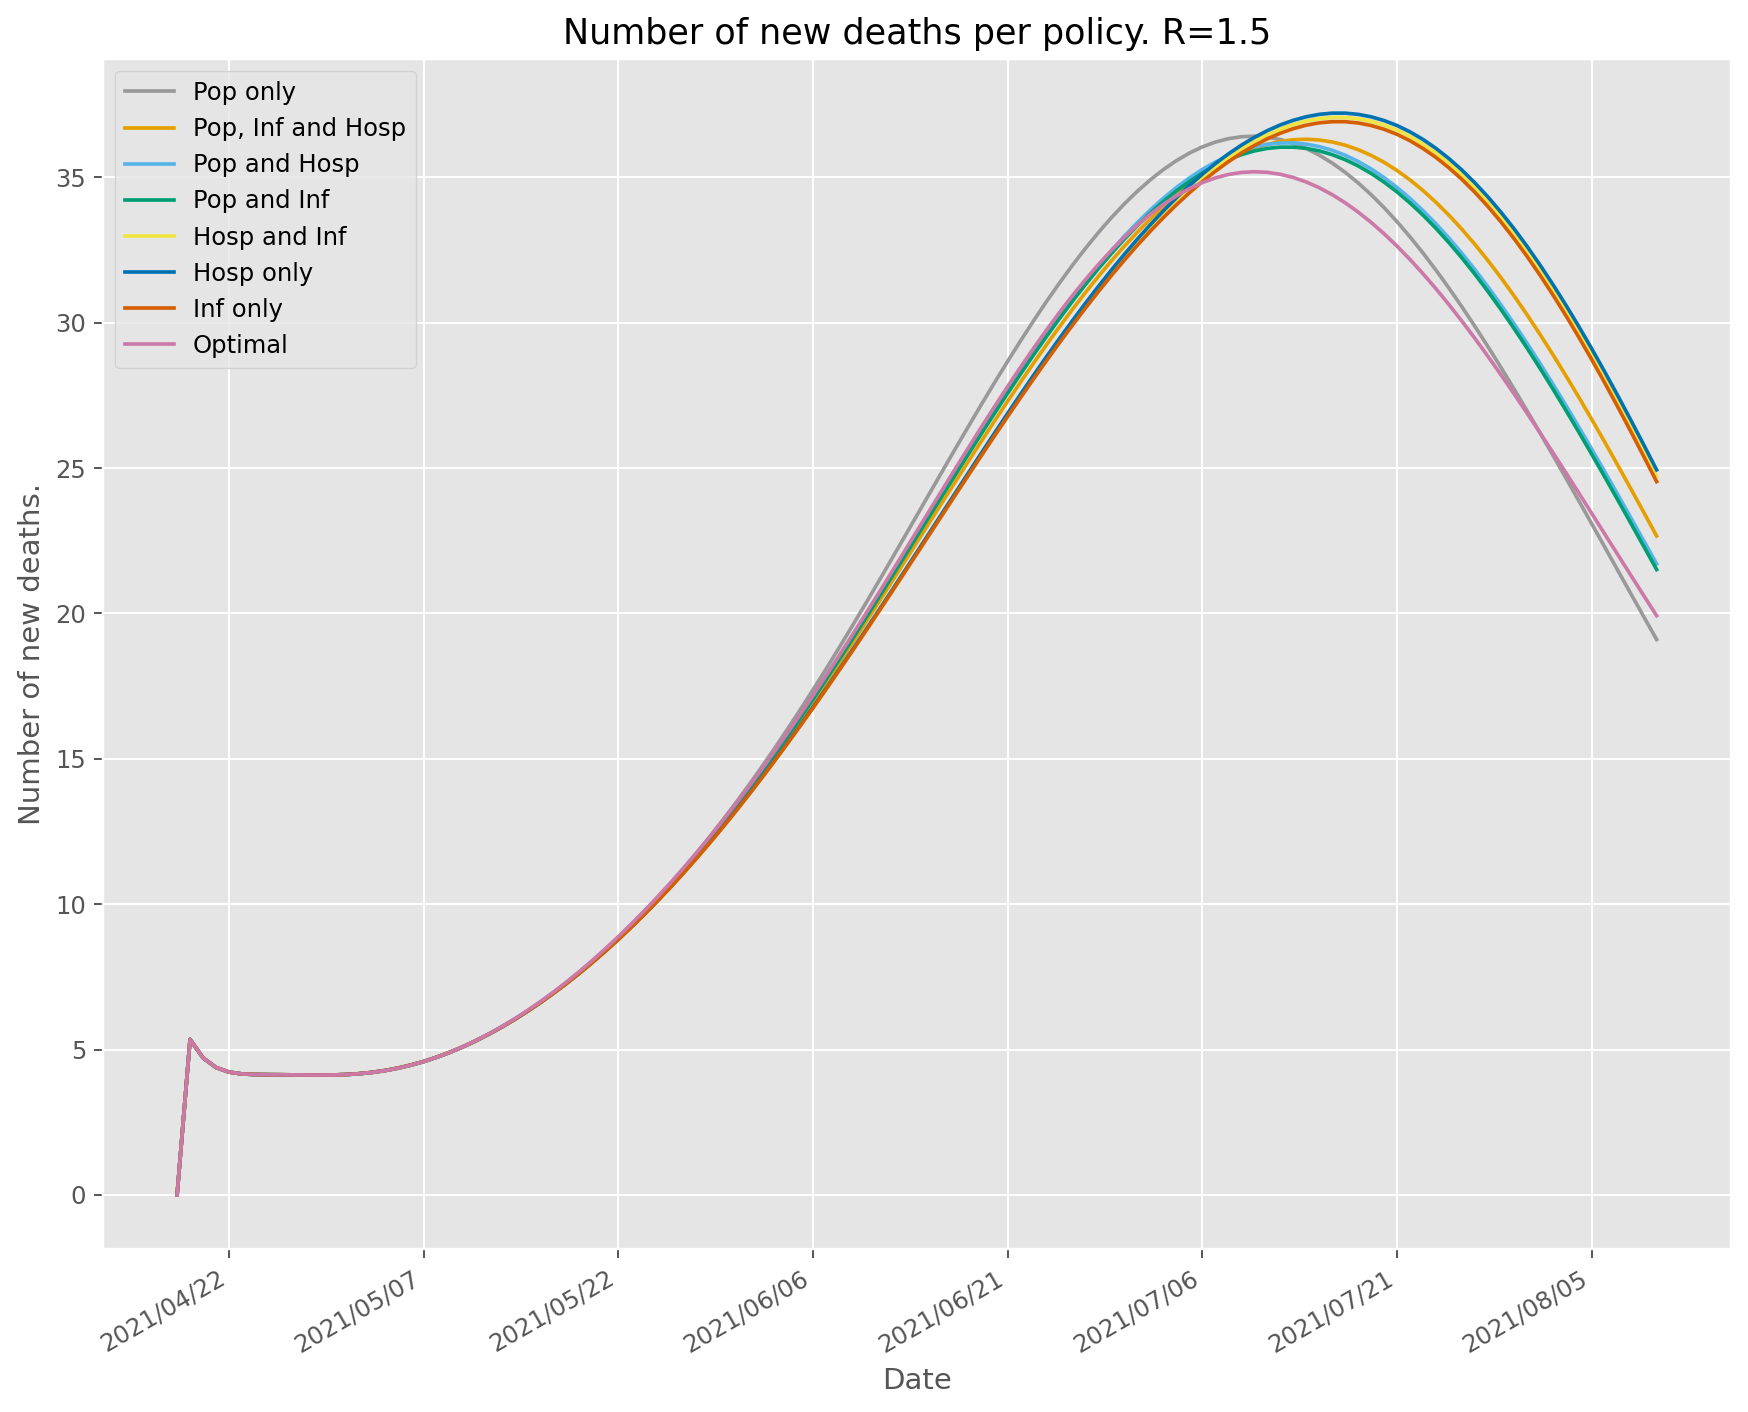

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[3], metric='new deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop only: 8633.465377655266
Pop and Inf: 8762.015797709439
Pop and Hosp: 8778.721235572291
Pop, Inf and Hosp: 8817.561400274377
Inf only: 8919.359048203976
Hosp and Inf: 8930.445252581781
Hosp only: 8942.140166254067


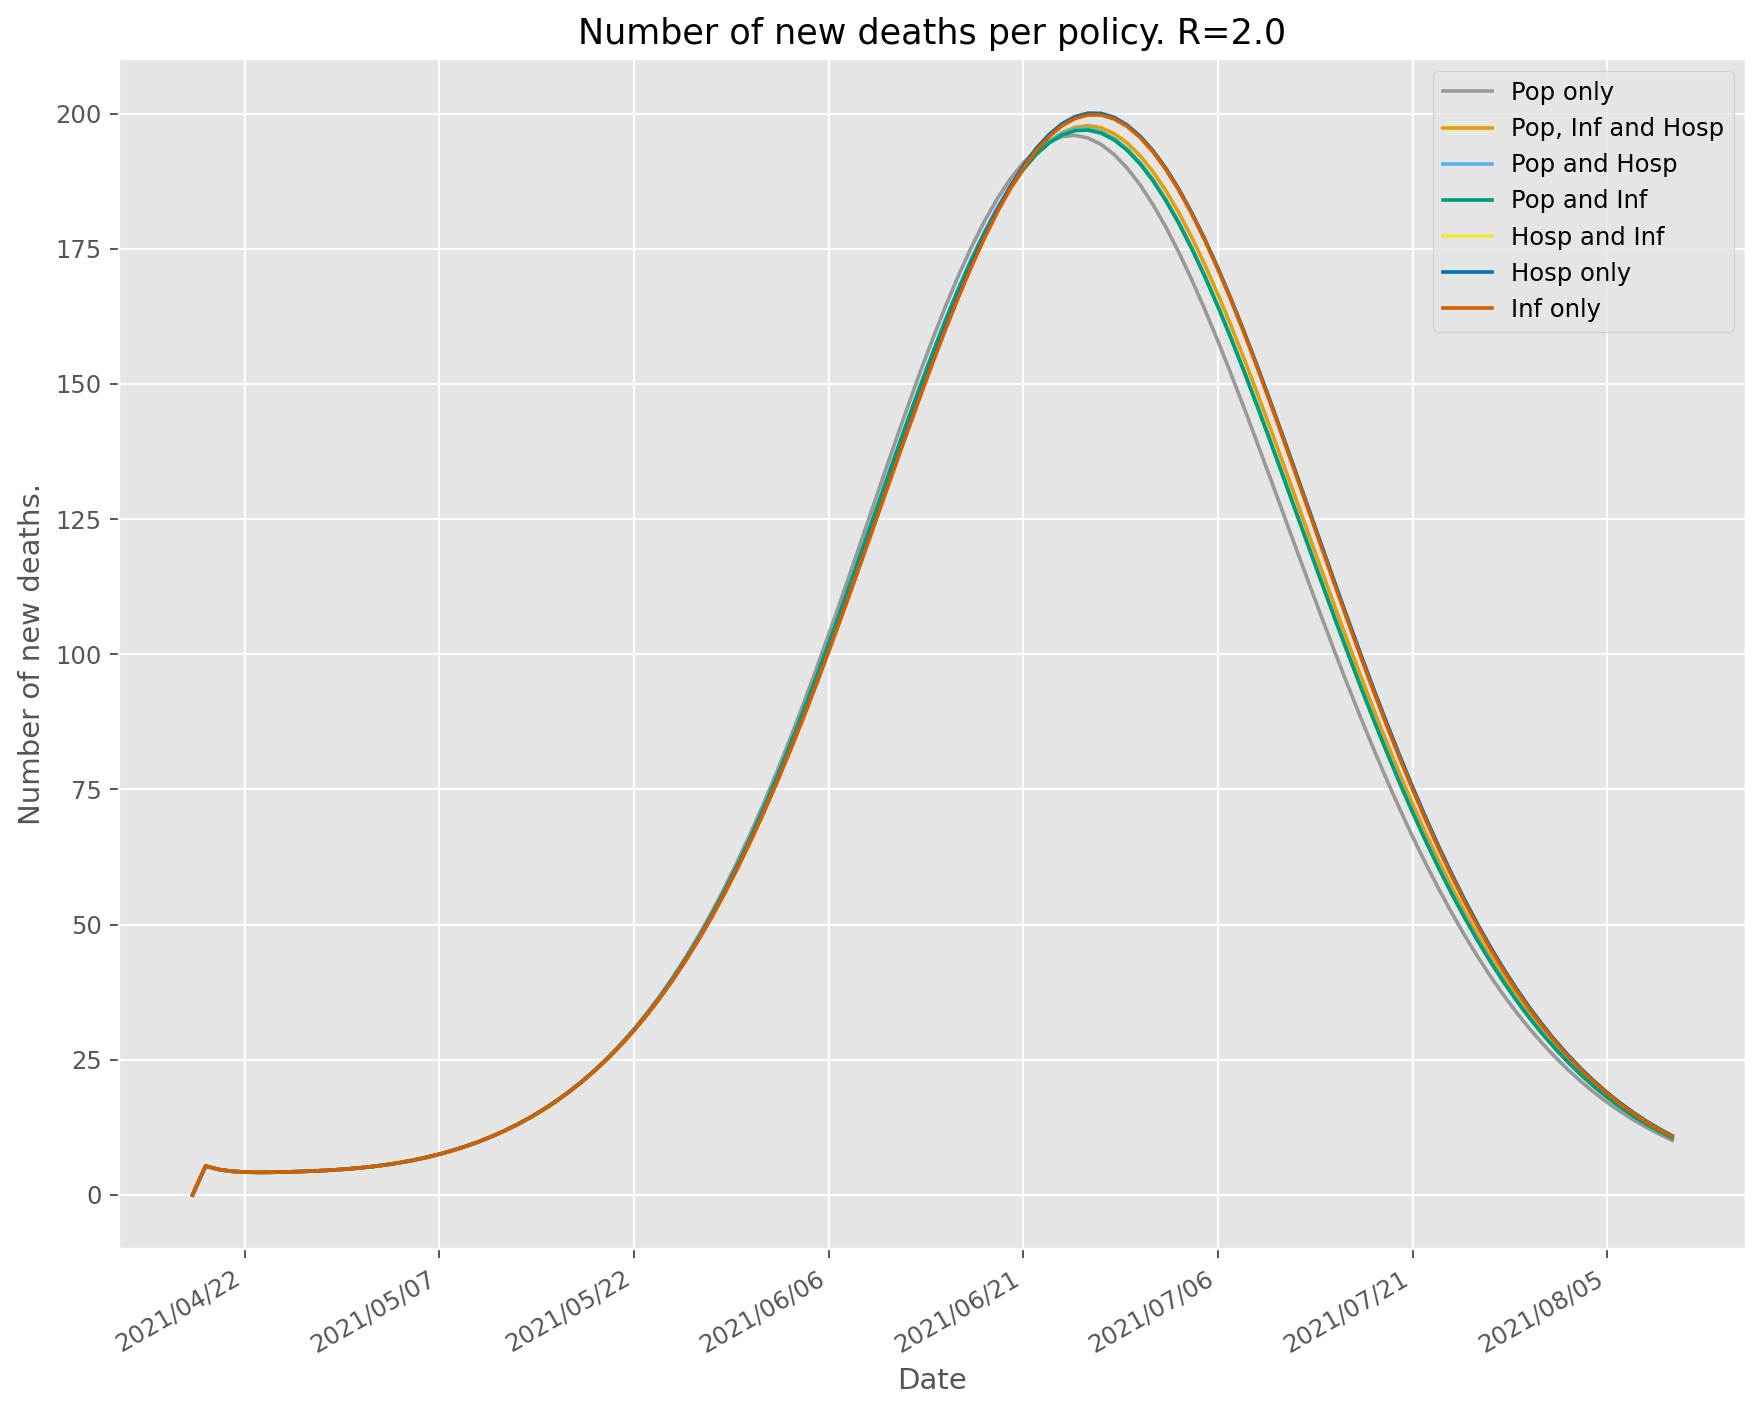

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[4], metric='new deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

# Hospitalizations

Inf only: 778.1308828237081
Hosp and Inf: 778.608808528534
Hosp only: 779.1299140523894
Pop, Inf and Hosp: 782.4139673407199
Pop and Inf: 784.5020255208962
Pop and Hosp: 784.9032098619914
Optimal: 787.2046580910127
Pop only: 793.37962213397


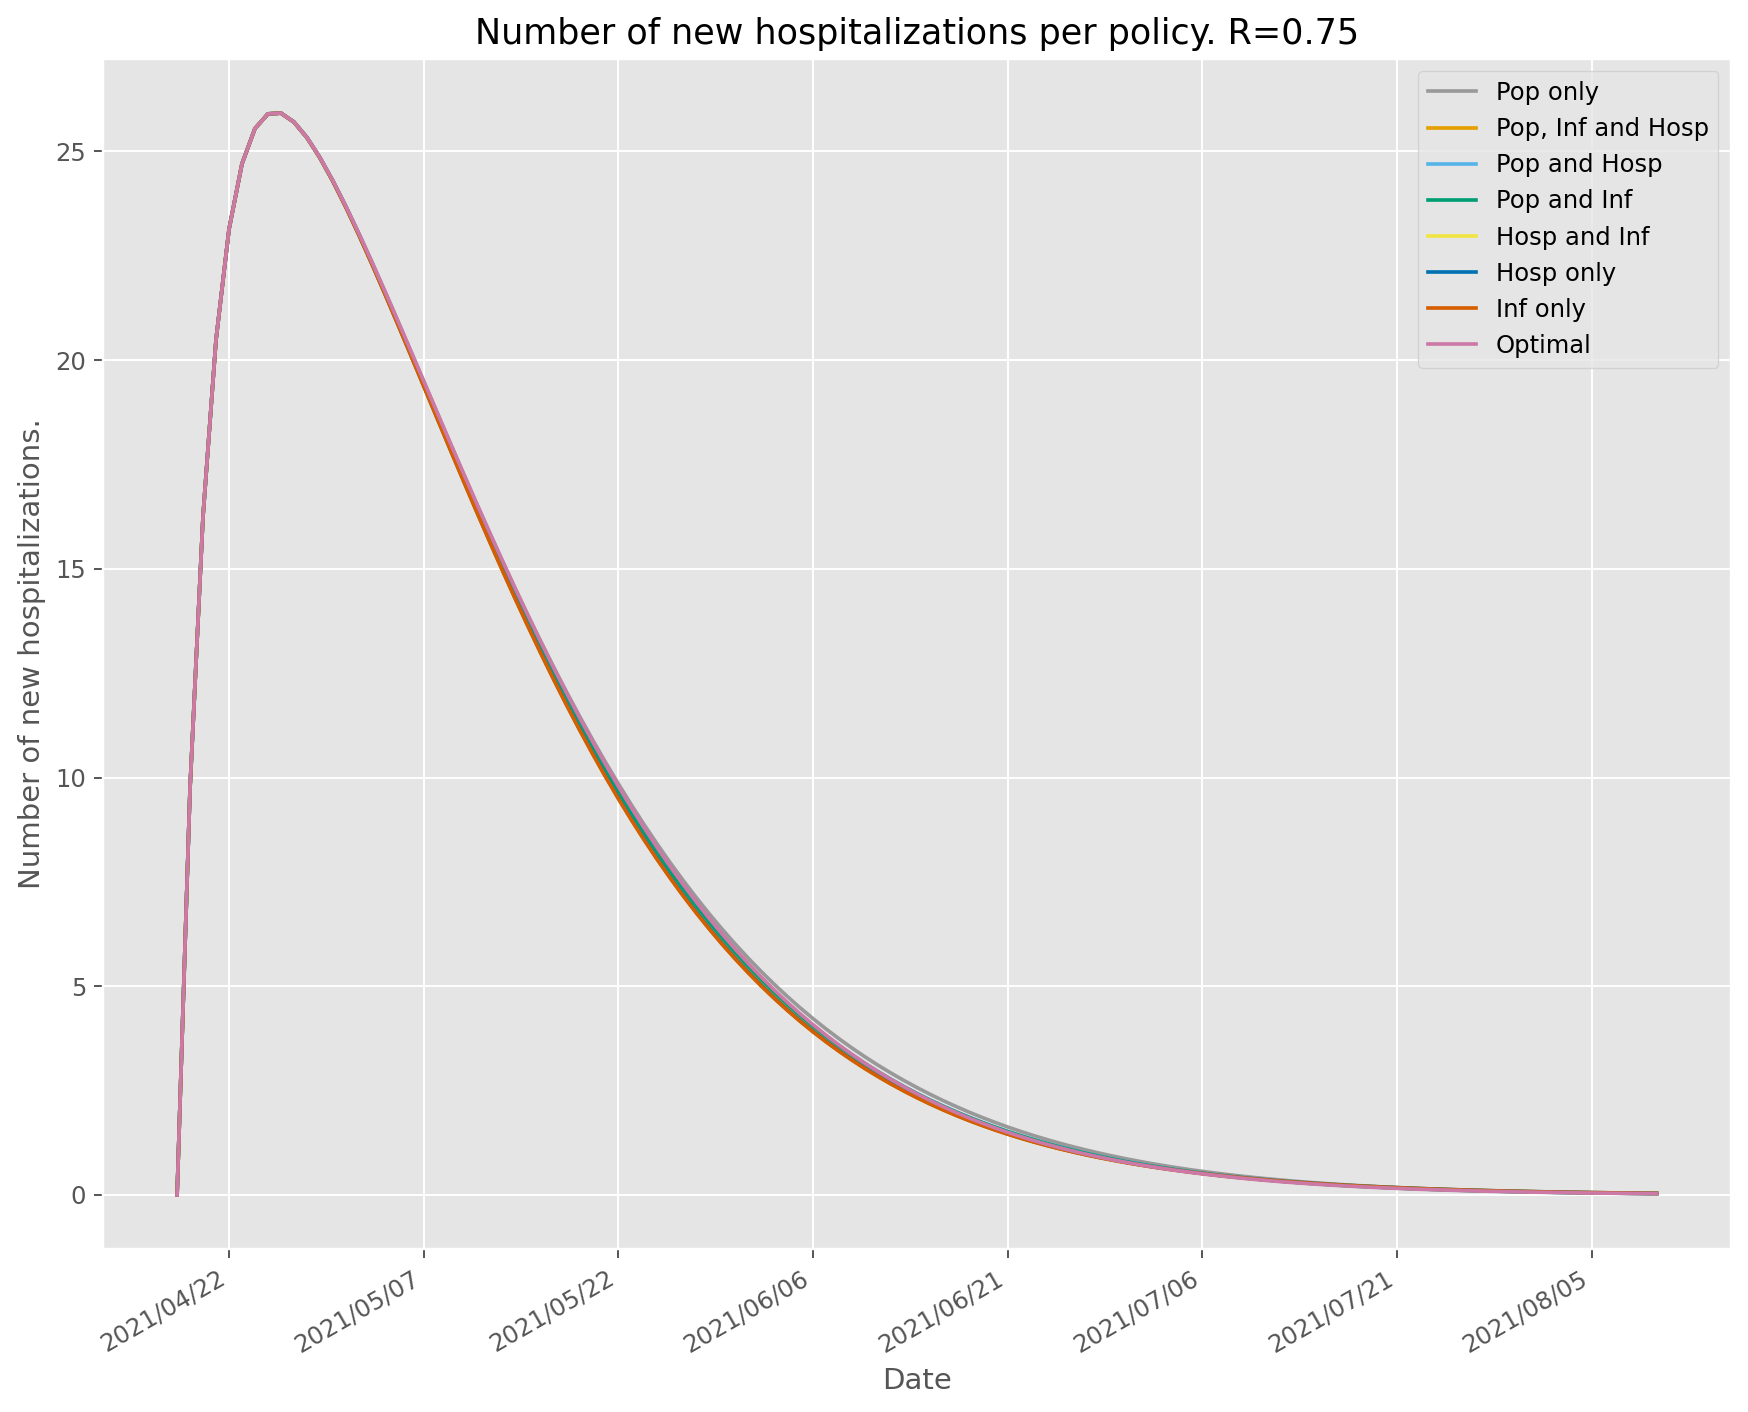

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[0], metric='new hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Inf only: 1926.4443390346116
Hosp and Inf: 1929.62443675057
Hosp only: 1933.311748849815
Pop, Inf and Hosp: 1938.57213016157
Pop and Inf: 1946.2018443463928
Pop and Hosp: 1948.8592485641495
Optimal: 1971.5401727544065
Pop only: 1998.9521803530274


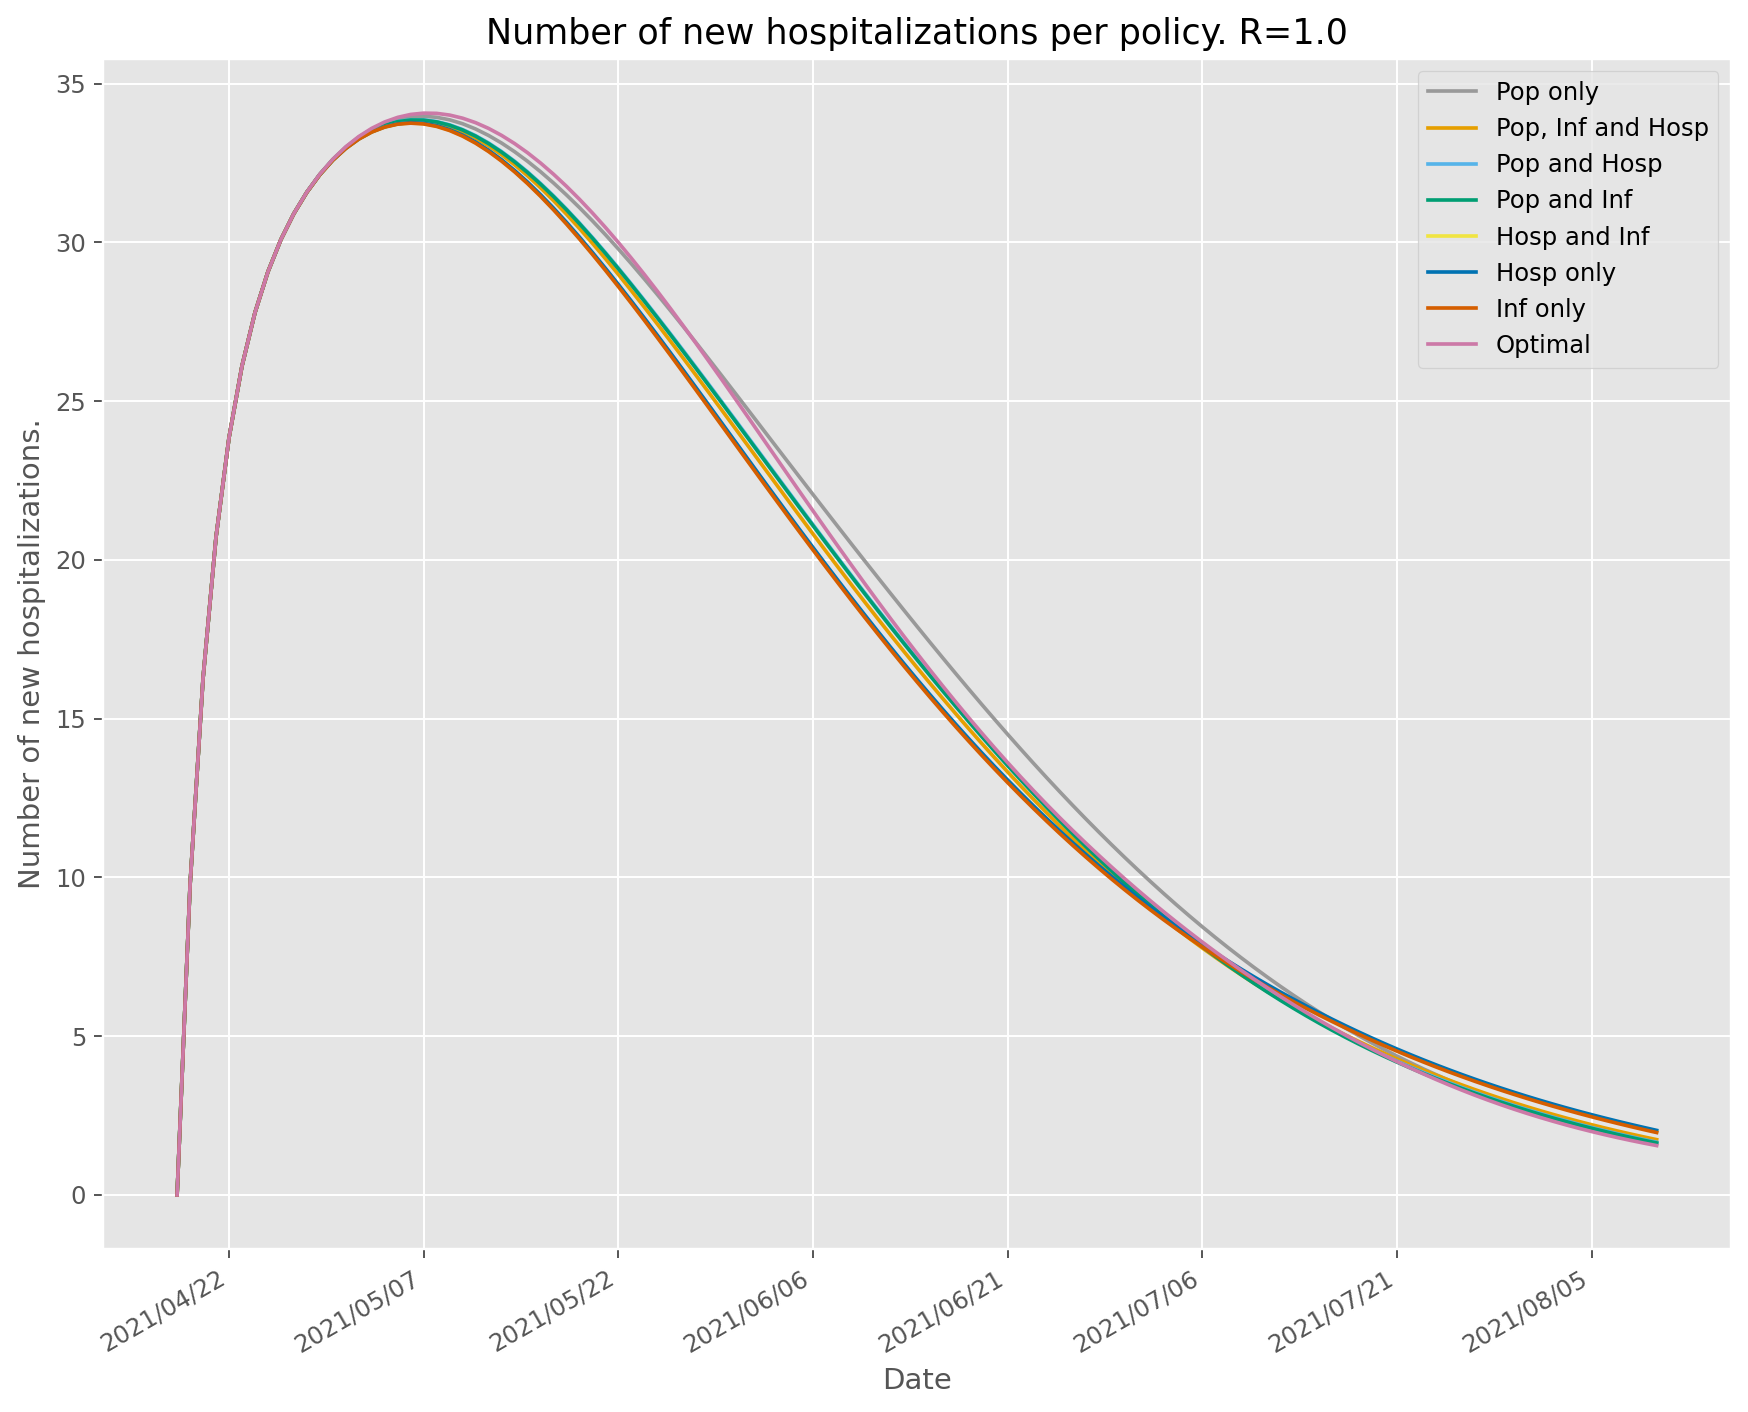

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='new hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop and Inf: 7200.331720522534
Pop and Hosp: 7224.660162226062
Pop, Inf and Hosp: 7233.566827521648
Optimal: 7317.650341193698
Inf only: 7326.02978829515
Hosp and Inf: 7352.145814674082
Hosp only: 7385.045203872908
Pop only: 7388.579176438054


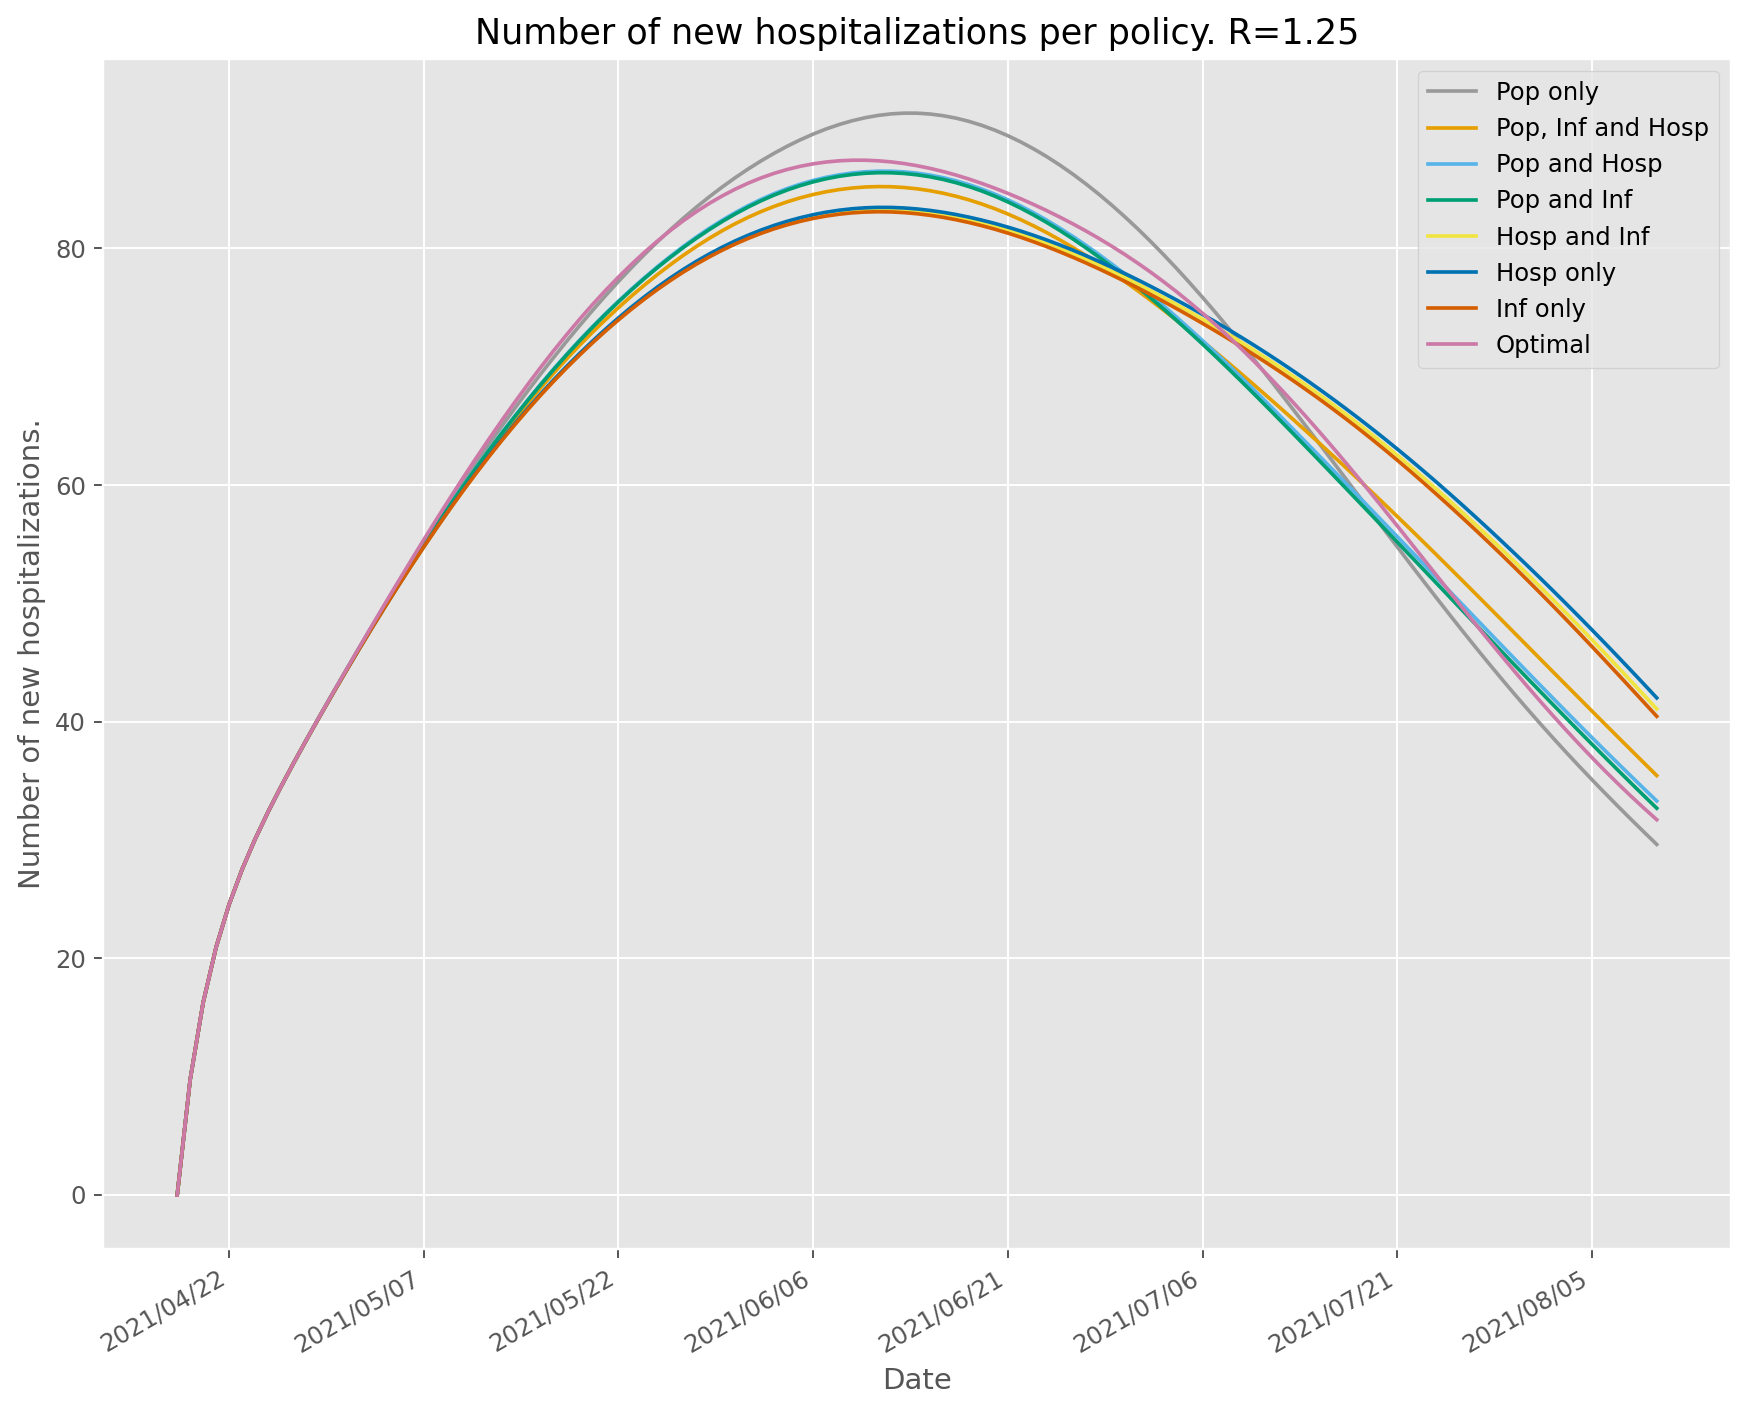

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='new hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop only: 25855.393888236882
Optimal: 25972.304872201203
Pop and Inf: 26067.868133285476
Pop and Hosp: 26182.425277615133
Pop, Inf and Hosp: 26475.17457690004
Inf only: 27303.763057381286
Hosp and Inf: 27409.845248161437
Hosp only: 27550.022279583474


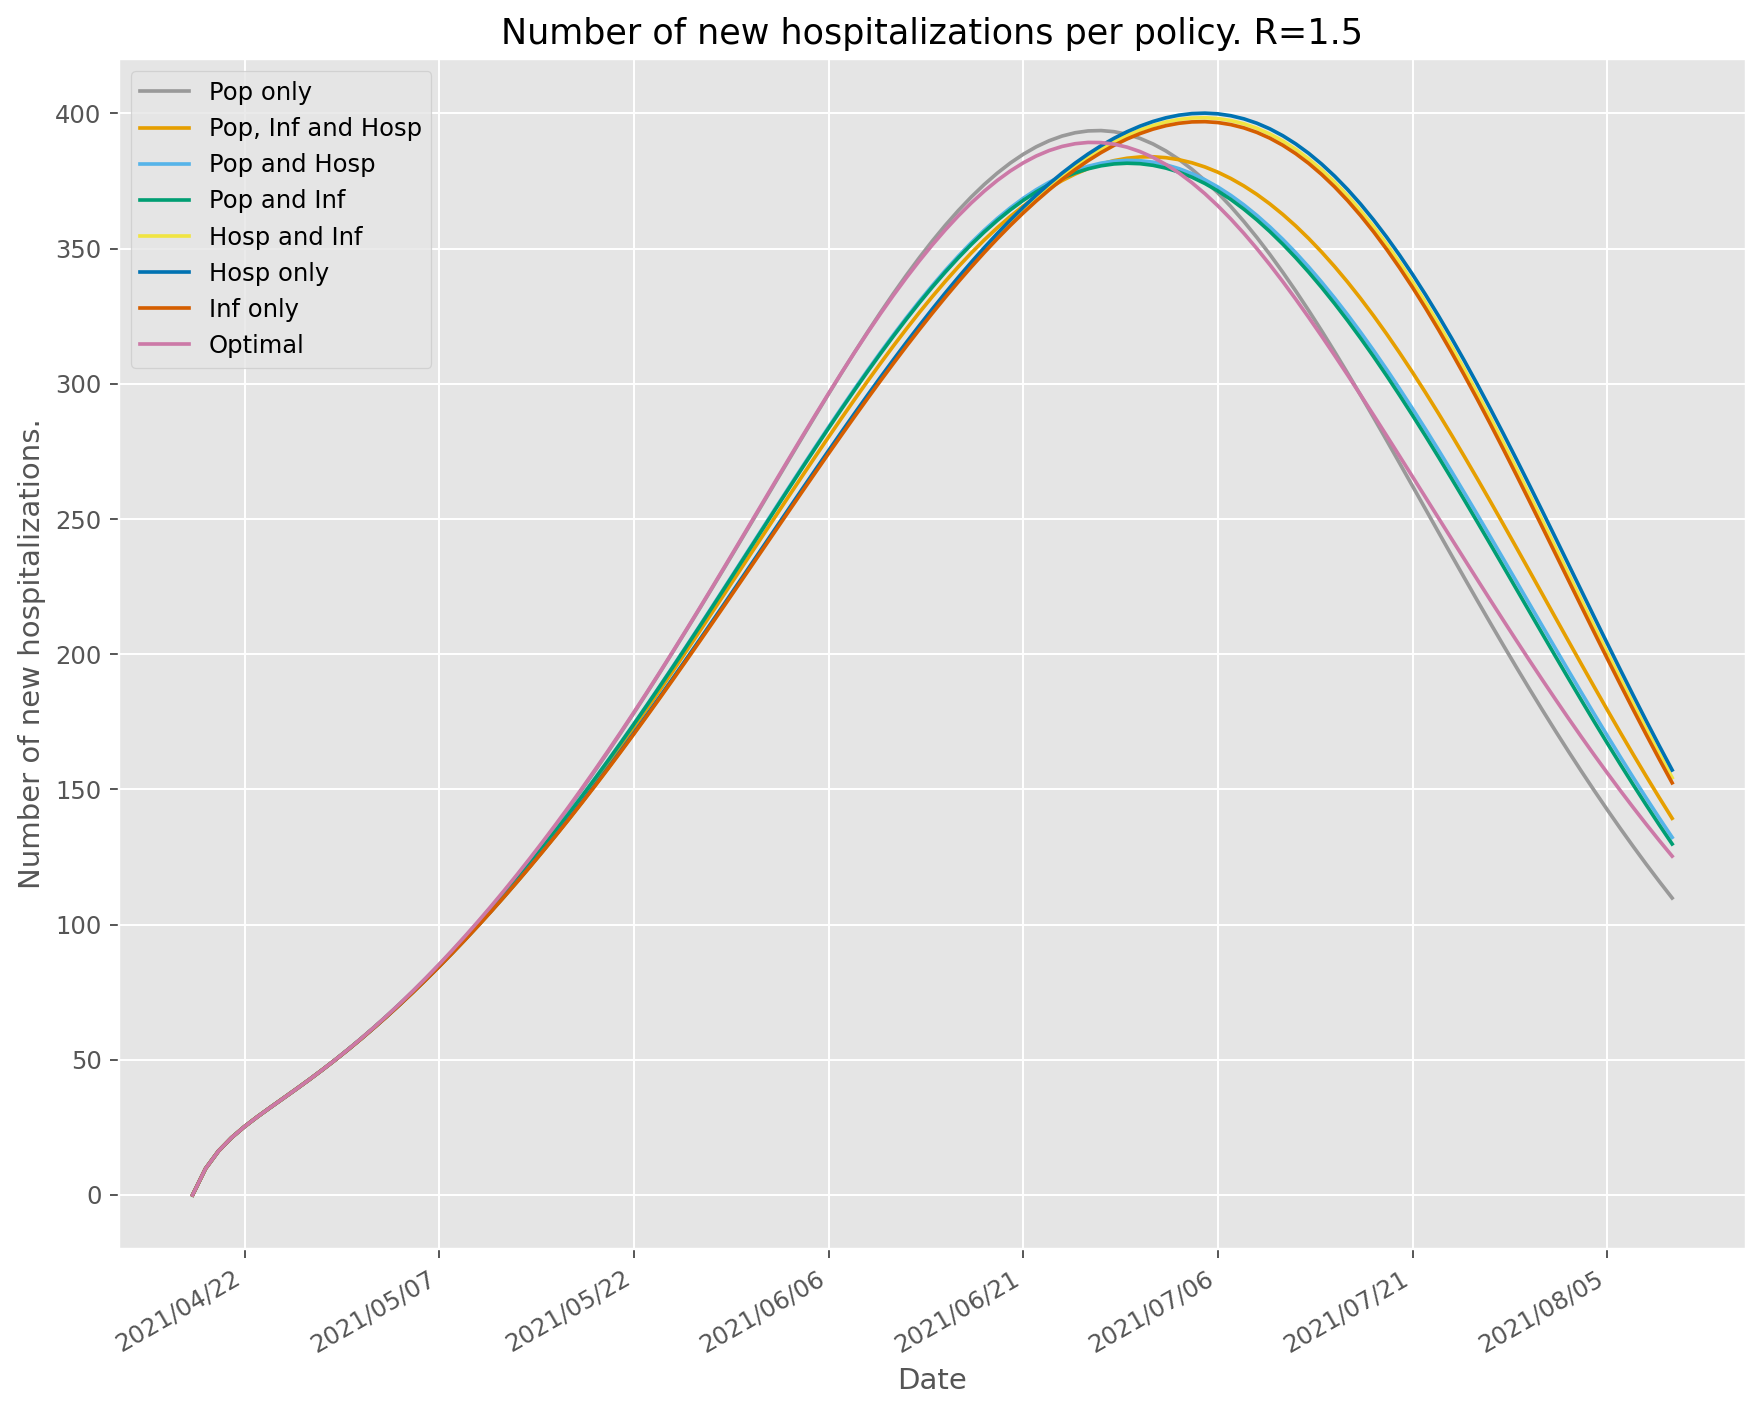

In [14]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[3], metric='new hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop only: 82952.09602692339
Pop and Inf: 84421.09388339687
Pop and Hosp: 84600.68094296951
Pop, Inf and Hosp: 85296.90222288585
Inf only: 87142.73603518105
Hosp and Inf: 87305.47269306598
Hosp only: 87493.87571474361


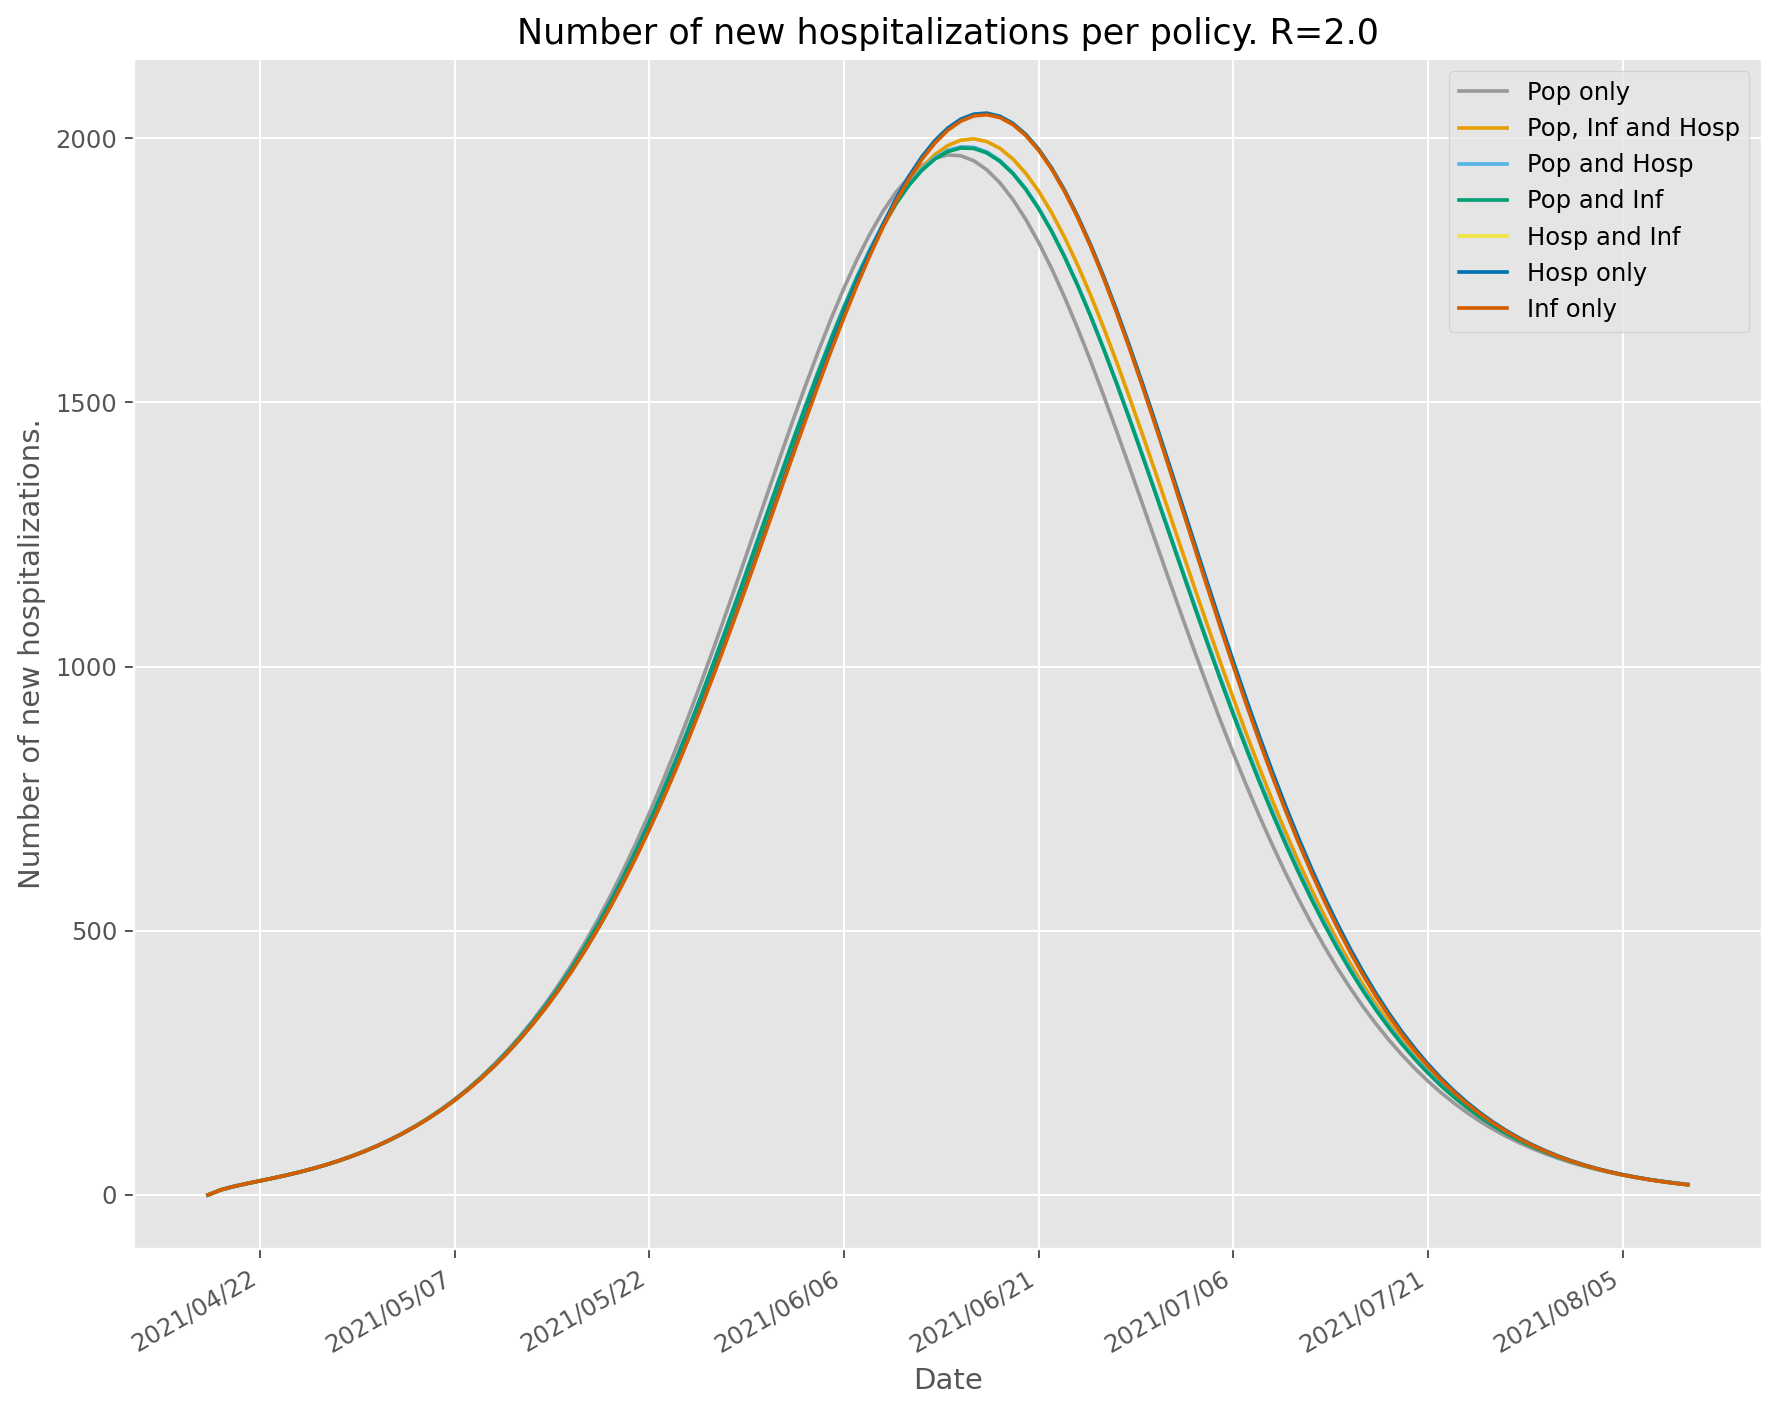

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[4], metric='new hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

# Infections

Optimal: 18888.08763037699
Inf only: 18990.974298283923
Hosp and Inf: 18995.488515025772
Hosp only: 18999.019977215004
Pop, Inf and Hosp: 19121.388016020148
Pop and Inf: 19184.286584471418
Pop and Hosp: 19187.172002757336
Pop only: 19391.503707314365


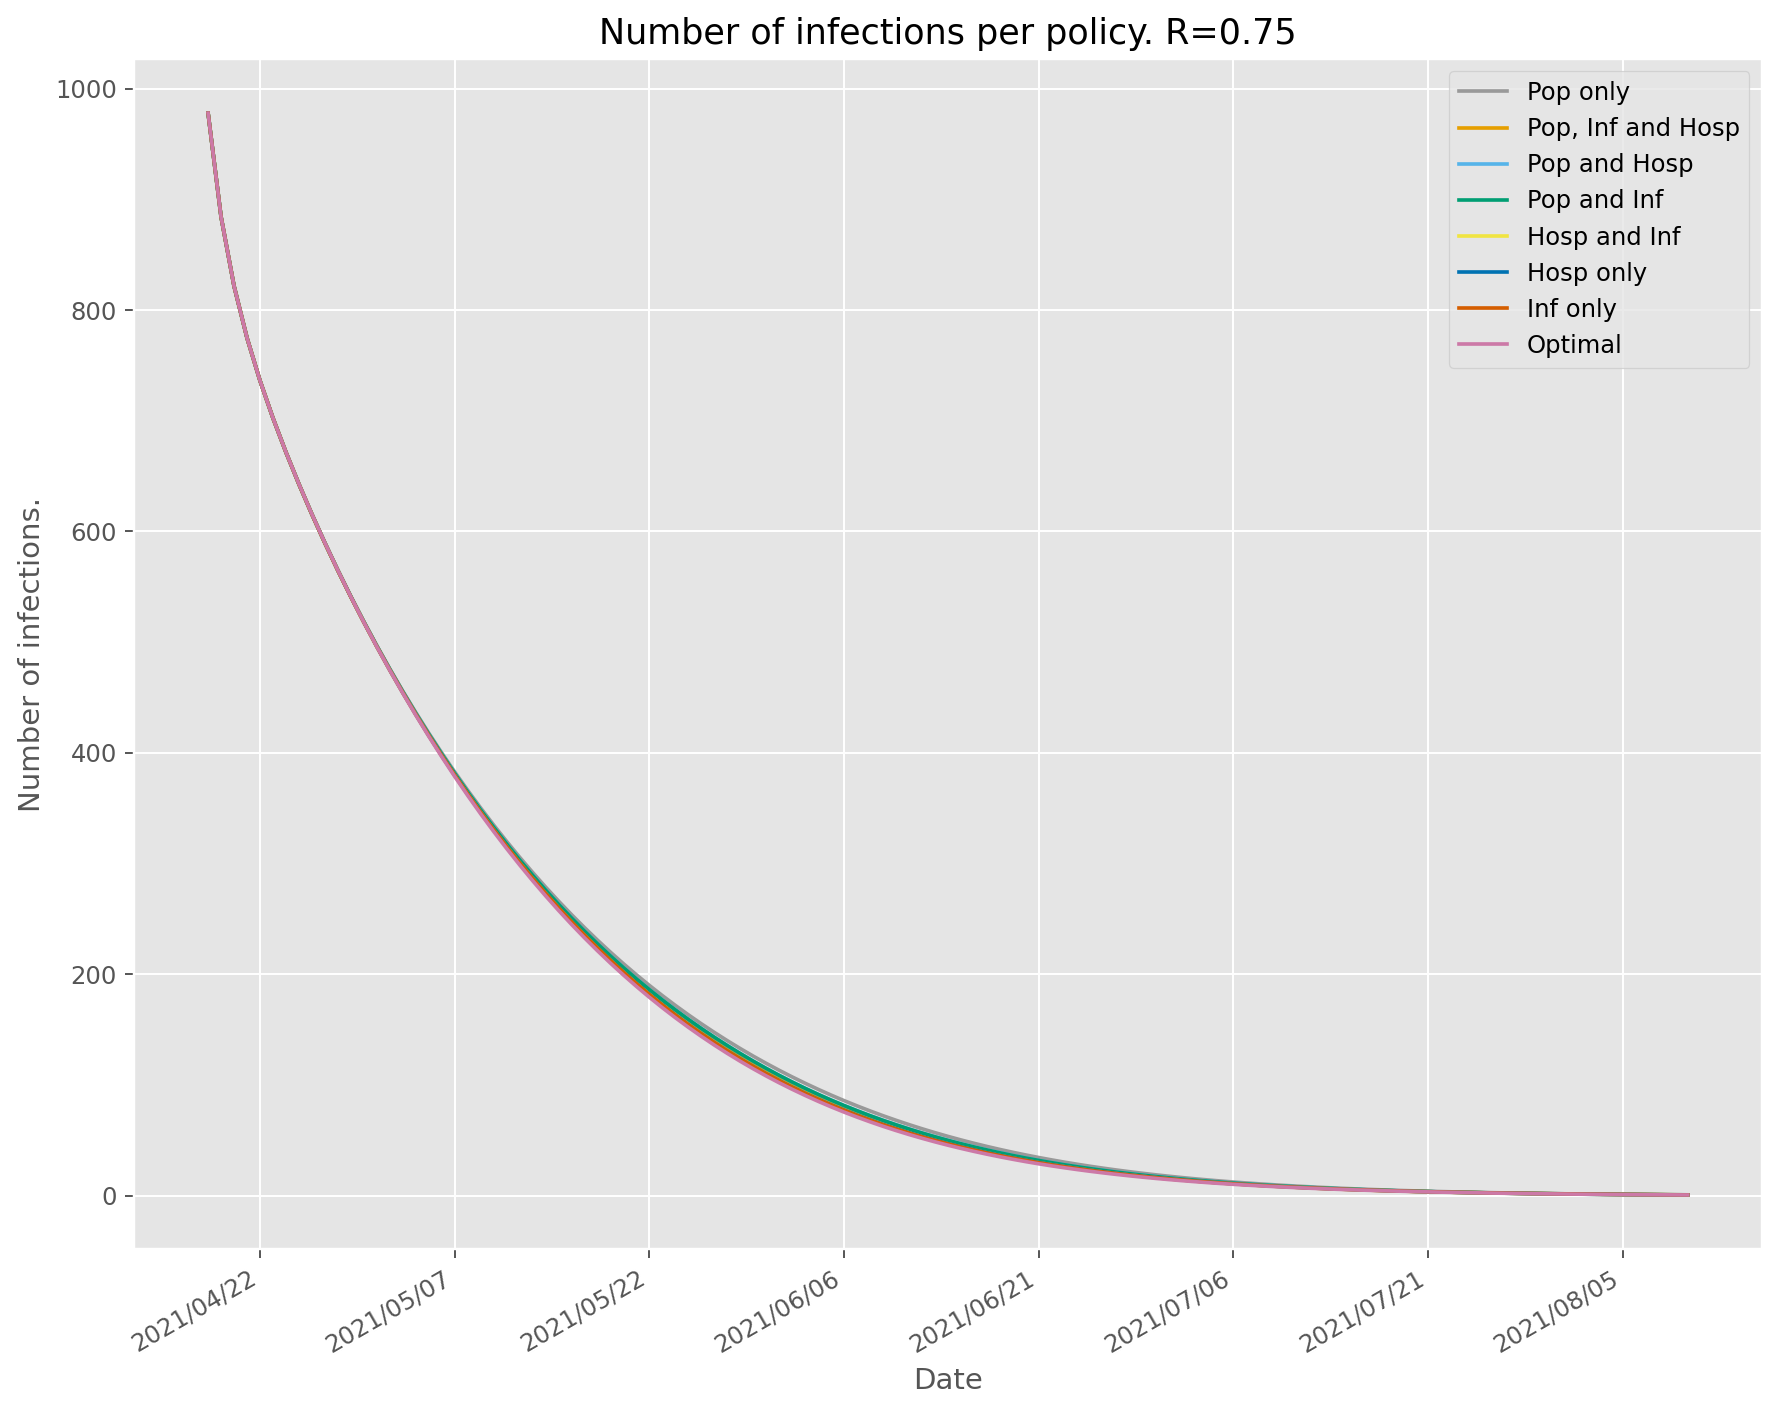

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[0], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Optimal: 52658.515405497834
Inf only: 54629.62315973789
Hosp and Inf: 54710.86253779422
Hosp only: 54791.17916904129
Pop, Inf and Hosp: 55391.26142240418
Pop and Inf: 55755.88374654828
Pop and Hosp: 55805.535384086084
Pop only: 57400.466059525344


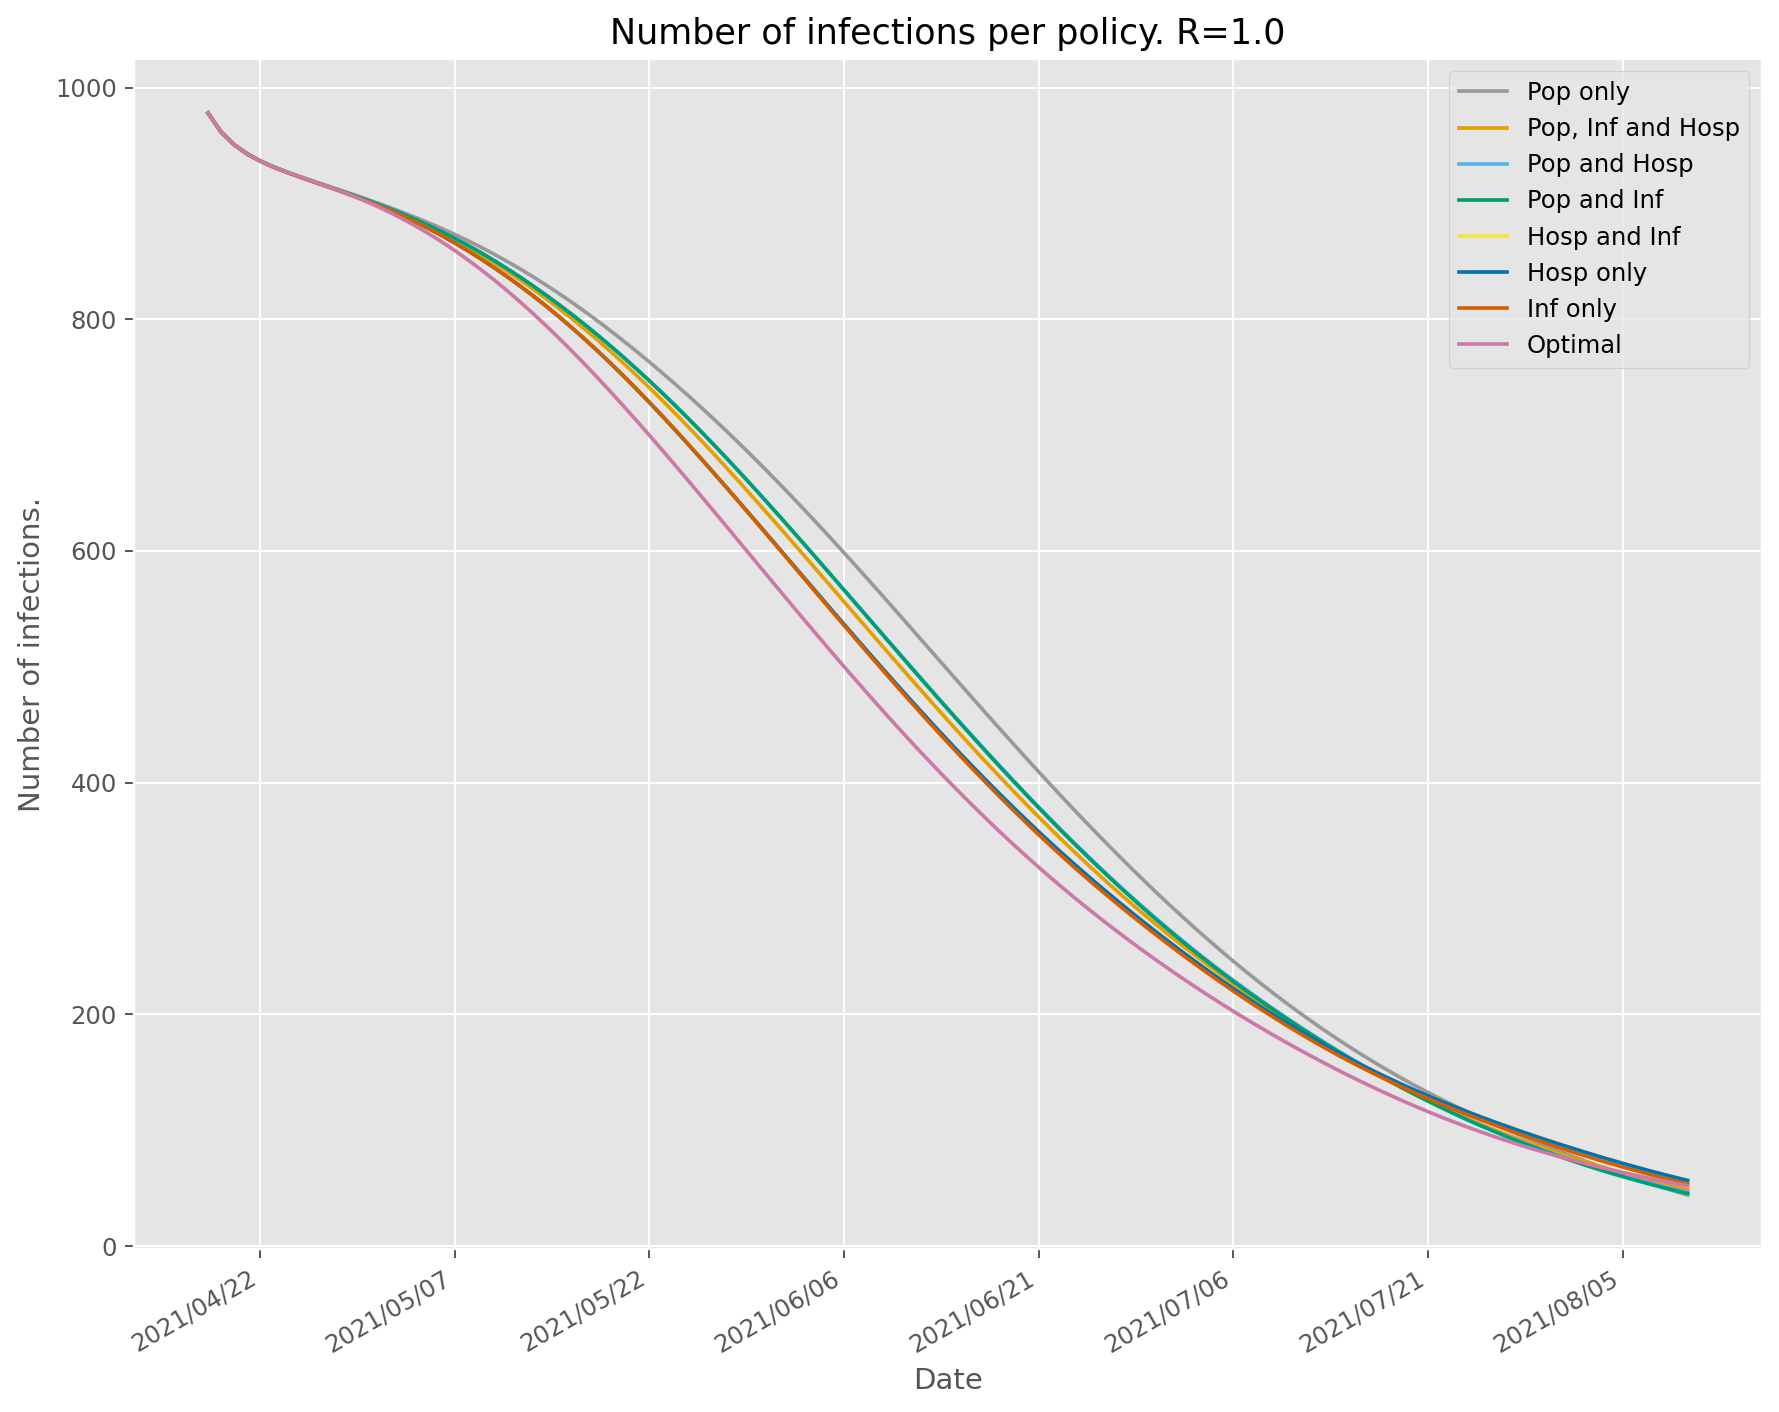

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Optimal: 224311.35059312845
Inf only: 240648.81042539666
Pop and Inf: 241625.30647845977
Pop, Inf and Hosp: 241660.20987599596
Hosp and Inf: 241747.0221903274
Pop and Hosp: 242382.24298219784
Hosp only: 242888.2747379596
Pop only: 248282.96116122833


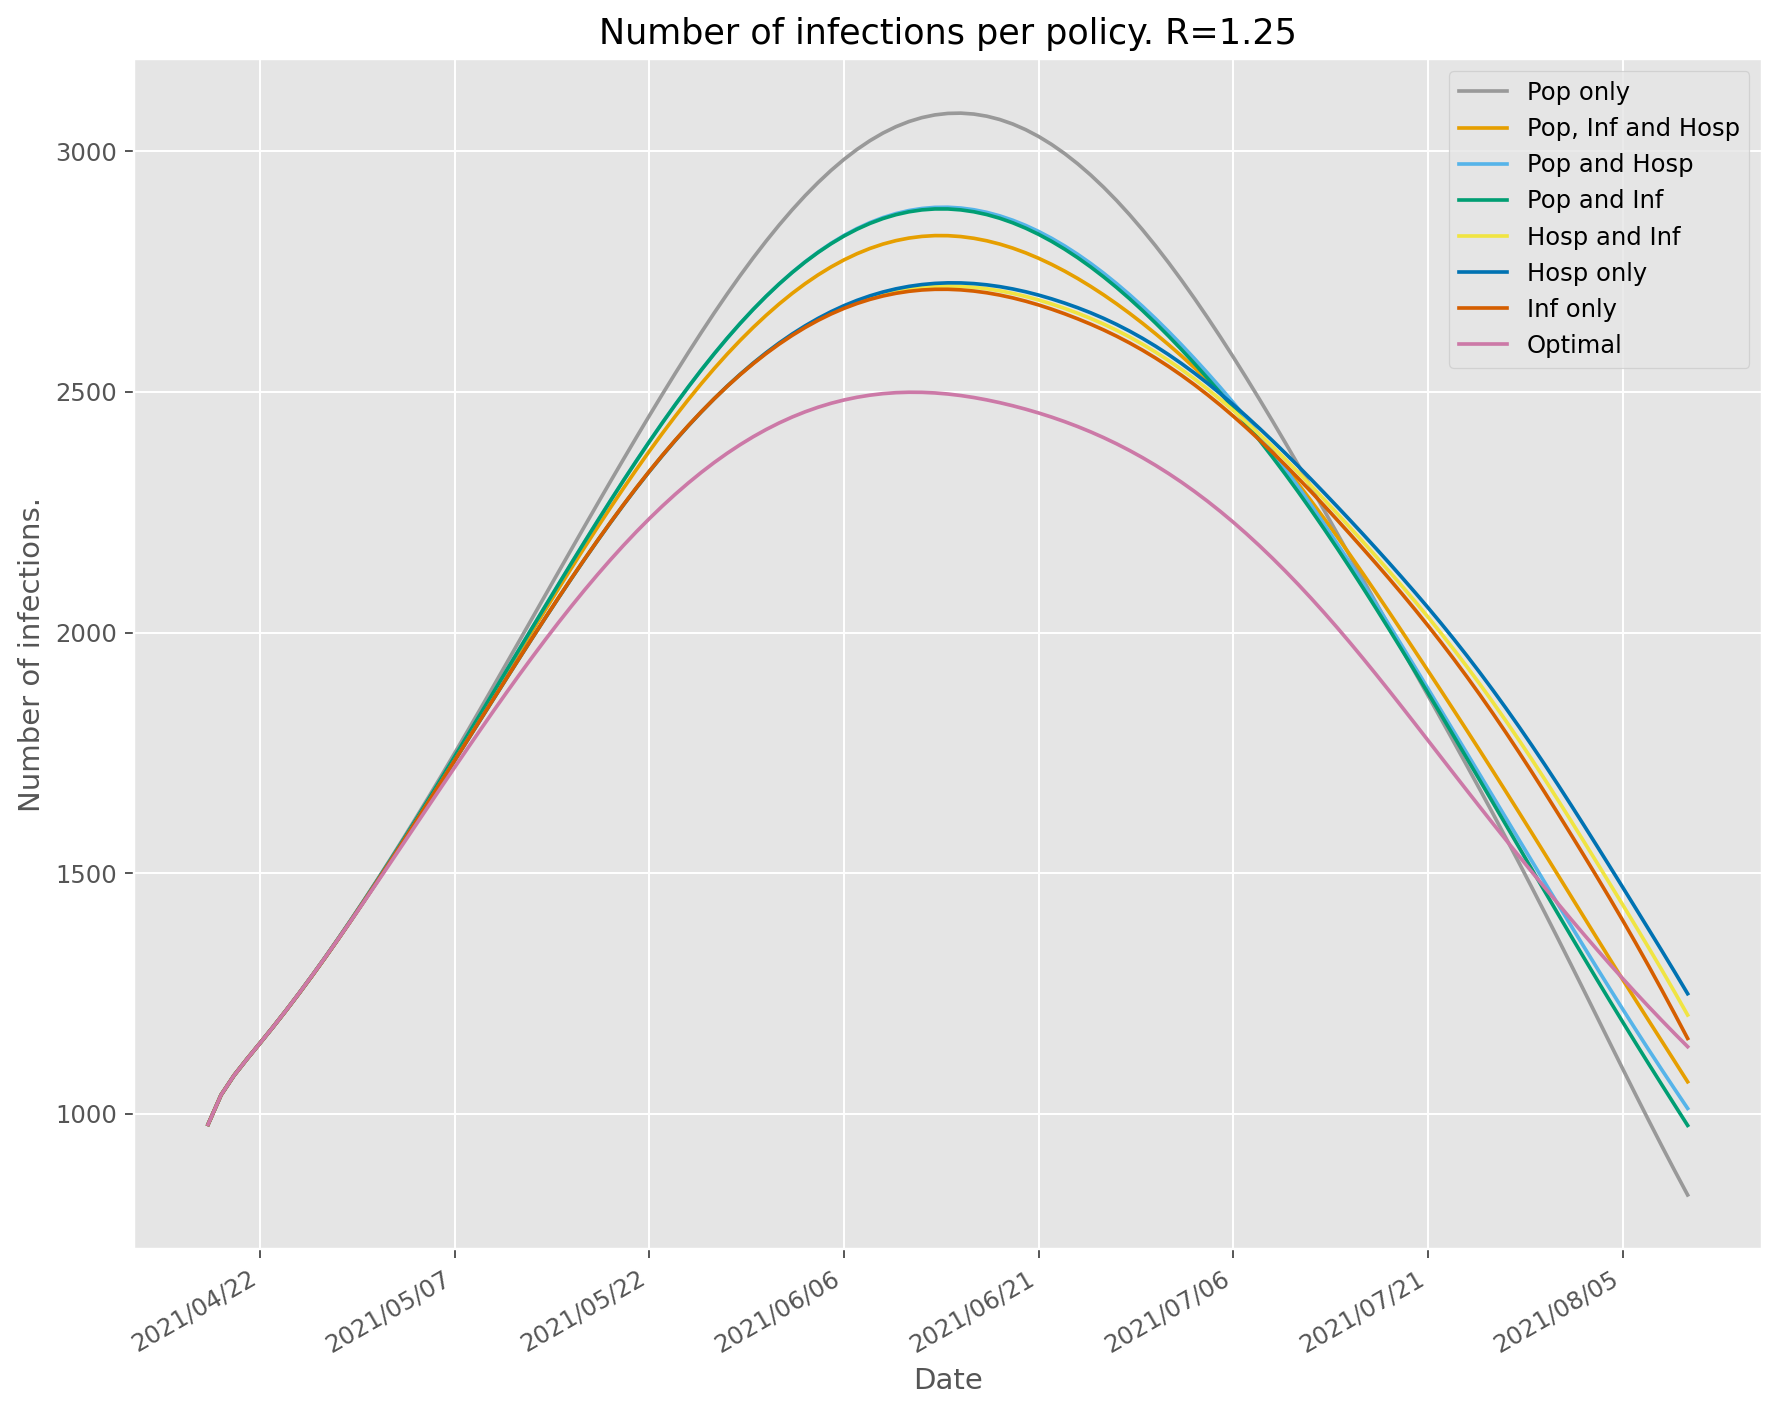

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Optimal: 831534.8051540119
Pop only: 843761.3452049551
Pop and Inf: 845449.0097350045
Pop and Hosp: 848556.7064622282
Pop, Inf and Hosp: 850882.8833318804
Inf only: 854124.9583379197
Hosp and Inf: 857829.6585708042
Hosp only: 861727.8329087294


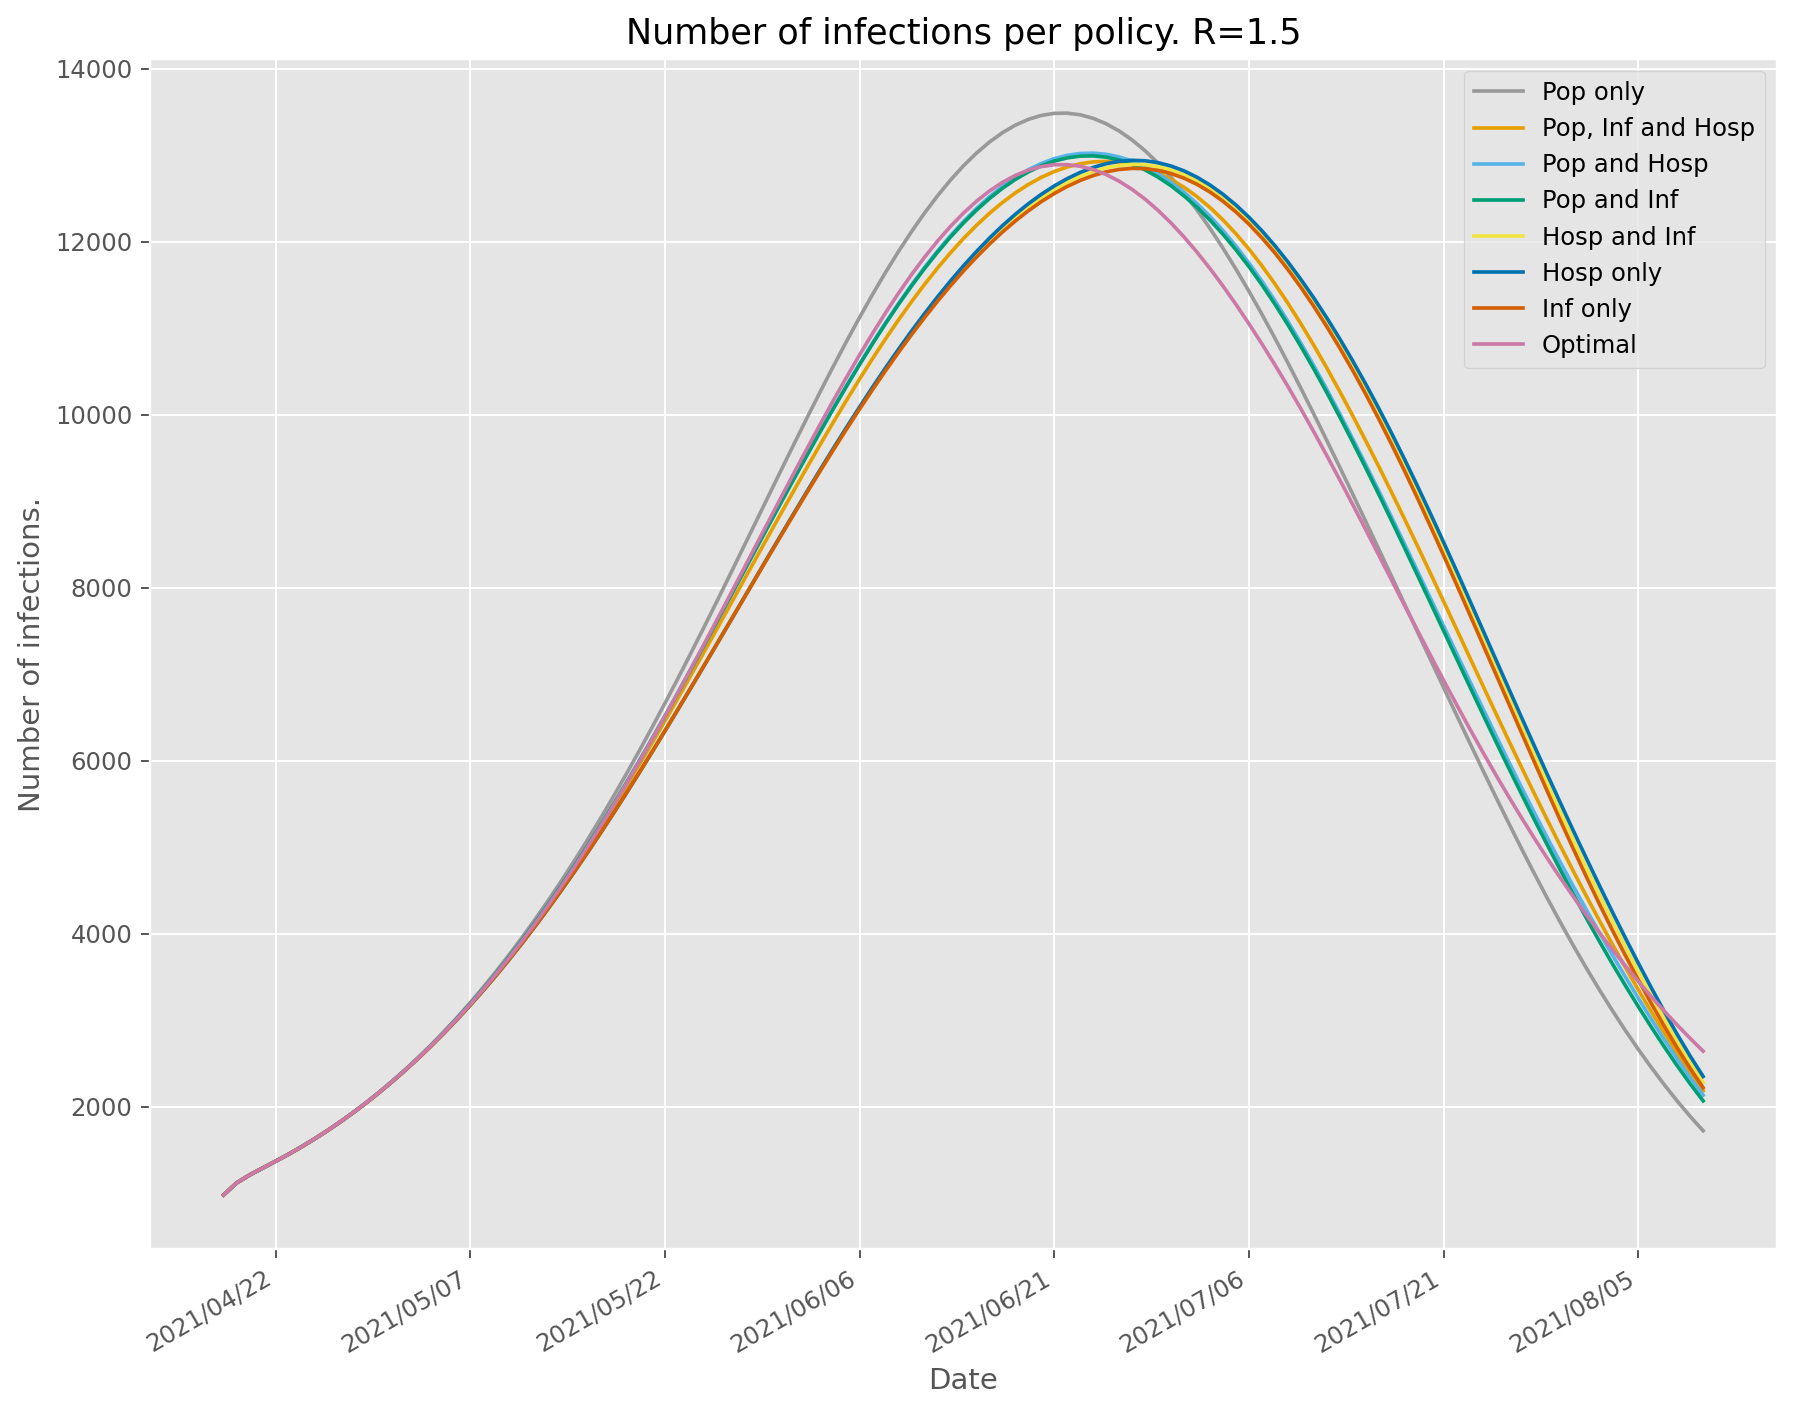

In [19]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[3], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop only: 2157945.189499287
Pop and Inf: 2166596.2999798846
Inf only: 2167442.7727608415
Pop and Hosp: 2169069.709113913
Pop, Inf and Hosp: 2169633.4186968384
Hosp and Inf: 2170190.2749827164
Hosp only: 2172573.8056938783


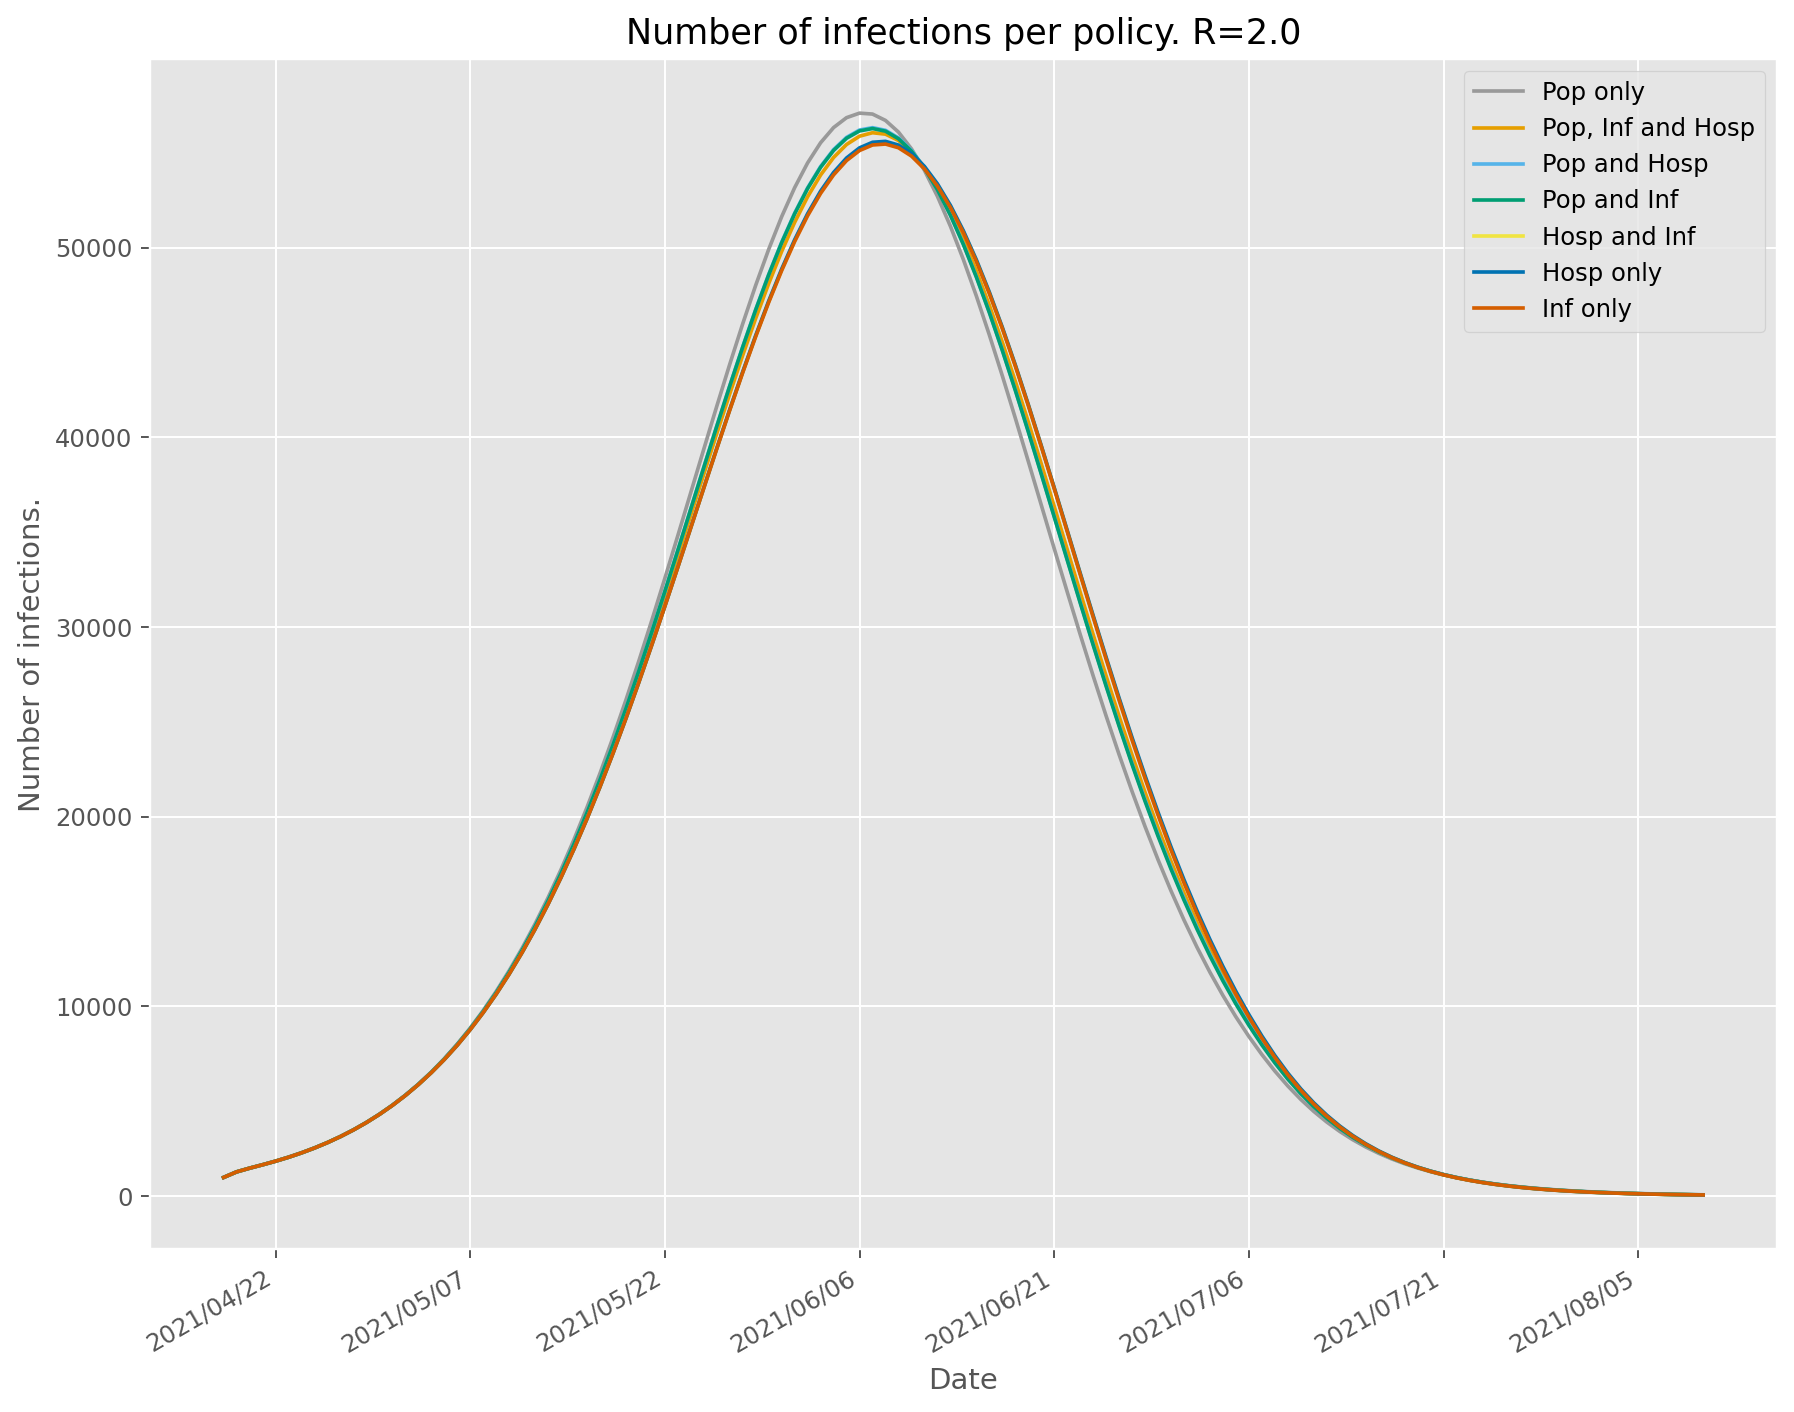

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[4], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()